## Bibliotecas e dados (MNIST)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
tensorDados = False

In [3]:

if tensorDados:
    import tensorflow as tf
    (adults_handWrit,  adults_digit), (teens_handWrit, teens_digit) = tf.keras.datasets.mnist.load_data()
    print("O numero de numeros manuscritos feitos por adolescentes foi: \t ", "{:.2e}".format(len(teens_digit)) ) 
    print("O numero de numeros manuscritos feitos por adultos foi: \t ",   "{:.2e}".format(len(adults_digit)))
    handWrit = np.concatenate( ([x.flatten() for x in adults_handWrit] , [x.flatten() for x in teens_handWrit]) )
    handWrit = np.array( [ x/np.amax(x) for x in handWrit ] )
    digits   = np.concatenate( (adults_digit, teens_digit) )


## Estrutura de dados usada para armazenar as entradas e saidas de cada exemplo

In [ ]:
class data:
    def __init__(self, x, y):
        self.entrada = x
        self.saida   = y

## Importando dados de MS960

In [4]:
if not tensorDados:
    from scipy.io import loadmat
    mat = loadmat("ex3data1.mat")
    X = mat["X"]
    Y = np.array(mat["y"])
    n = len(X)
    Y = [ Y.T[0][i] if Y.T[0][i] != 10 else 0 for i in range(n) ] 

## Parâmetros de inicialização

Para escolher o tamanho dos conjuntos de treino/teste.

In [148]:
p_treino = input("Insira o percentual do espaco amostral que deve ser usado para treino (numero entre zero e um).")
p_treino = float(p_treino)

if p_treino >= 1:
    p_treino = .9
if p_treino <= 0:
    p_treino = .1

p_teste = 1 - p_treino
    
print('O total de dados e ', n, '.')
print('Percentual para treino: ', 100* p_treino, '%.')
print('Percentual para teste:  ', 100* p_teste, '%.')

Insira o percentual do espaco amostral que deve ser usado para treino (numero entre zero e um)..001
O total de dados e  5000 .
Percentual para treino:  0.1 %.
Percentual para teste:   99.9 %.


## Embaralhando e separando entre treino e teste

In [ ]:
if not tensorDados:
    dados_MS960 = [data(X[i], Y[i]) for i in range(len(X))]
    np.random.shuffle( dados_MS960 )
    treino = dados_MS960[: int( p_treino*n ) -2 ]
    teste  = dados_MS960[int( p_treino*n ) -1 : ] # vamos ter no minimo 1 dado para teste
    plt.imshow(treino[0].entrada.reshape(20, 20))
    print(treino[0].saida)
    len(teste)

In [7]:
if tensorDados:
    dados = [data(handWrit[i], digits[i]) for i in range(len(digits))]
    np.random.shuffle( dados )
    treino = dados[: int( p_treino*n ) -2 ]
    teste  = dados[int( p_treino*n ) -1 : ] # vamos ter no minimo 1 dado para teste
    plt.imshow(treino[3].entrada.reshape(28, 28))
    print(treino[3].saida)

3


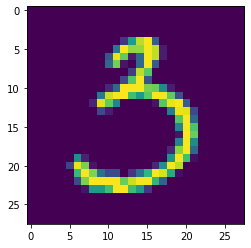

## Classe rede_neural

* **INICIALIZAÇÃO**: para inicializar a classe, é preciso fornecer:
    * os dados para o treino (que devem ser um objeto do tipo "data", definido acima);
    * a topologia da rede (um vetor em que cada elemento é o número de vetores por camada, sem considerar o bias);
    * constante para regularização (que deve ser zero caso não queira regularização).

In [169]:
from scipy.special import expit as sig# sigmoid function
class rede_neural:  # Custo da Rede Neural com a composicao atual de pesos
    def __init__(self, data, topologia_rede, lambida_reg):
        self.dados = data
        self.num_exemplos = len(data)
        self.As = 0 # As # vamos guardar a solucao dos As aqui
        self.bs = 0 # bs # vamos guardar a solucao dos bs aqui
        self.dim_entrada = topologia_rede[1]
        self.dim_saida   = topologia_rede[-1]  # dimensao da saida da rede neural
        self.num_camadas = len(topologia_rede)
        self.topo = np.array(topologia_rede) # vetor que indica quantos neuronios por camada; incluindo os elementos da entrada e da saida
        self.num_vars = np.sum( [self.topo[i] * self.topo[i+1] + self.topo[i+1] for i in range(len(self.topo)-1)] )  # estamos calculando qual o num total de variaveis; soma dos elementos das matrizes A e vetores b
        self.pesos_iniciais = ( np.random.rand(self.num_vars)  -  1/2 ) 
        #self.neuronios = [] # valor de cada neuronio (ativacao); vetor de vetores; o tamanho de cada vetor e dado pela topologia
        self.deltas = []  # erro de cada neuronio; msm arquitetura dos neuronios (cada neuronio tem um delta)
        self.J = []  # pra armazenar o custo e ver a curva de aprendizado por iteracao; tempo para aprender. outra curva interessante eh a de custo por num de exemplos (lembrando que dependendo das condicoes iniciais e do conjunto de exepplos dados podemos observar curvas diferentes msm se o num de exemplos for igual)
        self.DJ = np.zeros(self.num_vars)  # gradiente de J em funcao dos pesos; tem a msm dimensao de self.pesos_iniciais
        self.cont_teste = 0
        self.num_it = 0
        self.regularizacao = False
        self.lambida = lambida_reg
        
    def sol(self, teste): # dado um vetor imagem retorna a saida da rede neural
        x = teste
        for A, b in zip(self.As, self.bs):
            x = sig( x@A + b ) 
        return x
        
    # Embrulha e desembrulha sao necessarias pois a funcao scipy.optimize.minimize requer um vetor
    def embrulha(self, x): # dado um vetor de variaveis (os pesos da rede) monta as matrizes A e b da rede neural
        x = np.array(x) # x = pesos da rede neural
        As = []
        bs = []
        cont = 0
        for i in range(self.num_camadas - 1):
            m = self.topo[i]
            n = self.topo[i+1]
            p = m*n
            As.append(x[cont:cont+p].reshape(m, n))
            cont += p
            bs.append(x[cont:cont+n])
            cont += n
        return [As, bs]
        
    def desembrulha(self, As, bs): # dadas as matrizes As e bs da rede neural, retorna um vetor com os pesos
        x = []
        for A, b in zip(As, bs):
            x.extend(A.flatten())
            x.extend(b)
        return np.array(x)
    
    
    
    def cost_fun(self, pesos):
        self.num_it += 1
        self.pesos_iniciais = pesos # para nao perder o progresso se por acaso for interrompido pela metade; para ver a evolucao a cada iteracao;
        custo = 0 # zerando o custo 
        self.DJ = np.zeros(self.num_vars) # zerando o grad
        Abs = self.embrulha(pesos)
        As = Abs[0]
        bs = Abs[1]
        
        if self.lambida != 0:
            self.regularizacao = True
            
        if self.regularizacao:
            # o sinal é negativo pq o log ali em cima deixa negativo, mas la no final a gente retorna o negativo do custo
            custo -= self.lambida * np.square( self.desembrulha(As, [np.zeros(bs[l].shape) for l in range(len(bs)) ] ) ).sum() / (2*self.num_exemplos)
         
        
        for d in self.dados:  # neuronios nao precisa ser global da classe, pq muda pra cada exemplo (a menos que vc queira guardar todos os neuronios de todos os exemplos, teria alguma vantagem na velocidade de execucao?). arrumar isso dps
            res = np.zeros(self.dim_saida)
            res[d.saida] = 1
            x = d.entrada

            neuronios = []     # precisamos zerar para carregar novos exemplos
            neurocamada = [1]
            neurocamada.extend(x) # o 1 eh pq agr vamos usar a notacao de aula (matriz THETA, que junto A e b)
            neuronios.append(np.array(neurocamada))
            
            for A, b in zip(As, bs):
                x = sig( x@A + b ) 
                neurocamada = [1]
                neurocamada.extend(x) 
                neuronios.append(np.array(neurocamada))

            custo += (res*np.log(x)).sum() + ((1-res)*np.log(1-x)).sum()
                   
            #custo += ( (res - x)**2 ).sum() # custo de minimos quadrados; nao funcionou bem
            
            # daqui em diante é p/ calc. o grad da cost_fun
            neuronios[-1] = np.delete(neuronios[-1], 0) # estamos tirando o neuronio bias da ultima camada (pq nao existe na ultima)
            
            # A linha seguinte foi excluida pq ele foi feita em um contexto que eu precisava guardar simultaneamente o valor de todos os neuronios, visto que a funcao minimize espera duas funcoes diferentes para cost e para grad do cost; para resolver isso eu calculei tudo na cost e guardei o valor do grad globalmente na classe; preciso ver a ordem que a minimize chama as coisas para ver se funciona;
            #d.neuronios.append(neuronios) # adicionamos a ultima camada de ativacao no vetor de neuronios do exemplo d
            
            delta = [None]*(self.num_camadas) # o primeiro fica vazio pois a entrada nao tem erro
            delta[-1] = neuronios[-1] - res # pulamos a primeira posicao dos neuronios pq ela representa o bias, que nao tem conexao com a camada anterior (agora estamos usando a notacao da aula ao inves da nossa notacao xA+b; para obter a matriz theta basta fazer np.vstack(b, A).T)
            for i in range( (self.num_camadas-1) - 1, 0, -1 ): 
                delta[i] = (delta[i+1]@As[i].T) * neuronios[i][1:] * (1 - neuronios[i][1:])
            #print(len(neuronios), 'num de camadas com neuronios;', "neuronios: ", neuronios)
            
            DJtheta = [] # vamos append todas as matrizes theta aqui
            for i in range(self.num_camadas-1):
                DJtheta.append( np.vstack(  (np.zeros(bs[i].shape), np.zeros(As[i].shape)) ).T ) # arquitetura das derivadas parciais de J na notacao de THETA vista em aula
            teste_num_pesos = 0
            for l in range(self.num_camadas-1):
                for i in range(self.topo[l+1]):
                    for j in range(0, self.topo[l]+1): # +1 pq nessa notacao contabilizamos o bias na matriz theta
                        teste_num_pesos += 1
                        DJtheta[l][i,j] = neuronios[l][j] * delta[l+1][i]  
                        if self.regularizacao and j != 0: # j == 0 é o bias ne?
                            DJtheta[l][i,j] += self.lambida*As[l][j-1, i]/self.num_exemplos  # conferir se eu to pegando a aresta (peso) certa
                            # conferir se era pra dividir por num_exemplos; acho que sim pq nao era pra isso tá dentro do for dos exemplos
            #print(teste_num_pesos)
            theta_to_As = []
            theta_to_bs = []
            Abstheta = [  [ theta_to_As.append(DJtheta[i].T[ np.arange(self.topo[i] )+ 1 ]), theta_to_bs.append(DJtheta[i].T[[0]][0]) ] for i in range(self.num_camadas-1) ]
            #print(Abstheta, theta_to_As, theta_to_bs)
            
            # Somando o grad do i-esimo exemplo ao grad total
            self.DJ += self.desembrulha( theta_to_As, theta_to_bs ) / self.num_exemplos
            
        self.cont_teste += 1
        #print(self.cont_teste, -custo/self.num_exemplos)
        
        self.J.append(-custo/self.num_exemplos)
        return -custo/self.num_exemplos, self.DJ
    
    # Acabou nao precisando pq a funcao scipy.optimize.minimize aceita que a funcao objetivo retorne o gradiente junto, basta fazer jac = True
    def grad_cost_fun(self, pesos):
        if (self.pesos_iniciais == pesos).all():
            return self.DJ
        else:
            print("Gradiente atrasado (o mesmo da iteracao anterior).")
            return self.DJ
    
    
    
    
    def grad_desc(self, theta, alpha, max_iter, Lambda, epsilon, check_DJ):
        
        J_history = []
        
        for i in range(max_iter):
            cost, DJ = self.cost_fun(theta)
            # Check das derivadas pelo Método da Secante
            if(check_DJ):
                for j in range(self.num_vars):
                    EPSILON = np.zeros(self.num_vars)
                    EPSILON[j] = epsilon
                    dif_custo = (self.cost_fun(theta+EPSILON)[0]-self.cost_fun(theta-EPSILON)[0])/(2*epsilon)
                    #print(DJ[j], dif_custo)
                    print(j, "A razão entre as derivadas é:", dif_custo/DJ[j])
            theta = theta - (alpha * DJ)
            J_history.append(cost)        
        return theta, J_history

## Importando os dados da aula (MS960)

In [170]:
from scipy.io import loadmat
mat = loadmat("ex3data1.mat")
X = mat["X"]
Y = np.array(mat["y"])
n = len(X)
Y = [ Y.T[0][i] if Y.T[0][i] != 10 else 0 for i in range(n) ] 

## Tratando os dados

5


4996

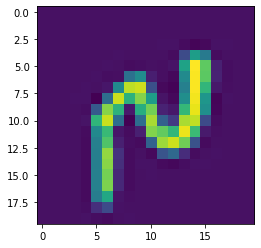

In [171]:

dados_MS960 = [data(X[i], Y[i]) for i in range(len(X))]
np.random.shuffle( dados_MS960 )
treino = dados_MS960[: int( p_treino*n ) -2 ]
teste  = dados_MS960[int( p_treino*n ) -1 : ] # vamos ter no minimo 1 dado para teste
plt.imshow(treino[0].entrada.reshape(20, 20))
print(treino[0].saida)
len(teste)

## Minimizacao pelo gradiente descendente

In [172]:
alpha = 0.01
max_iter = 50
Lambda = 0
epsilon = 0.2
print(len(treino))
rede1 = rede_neural(treino, [400, 25, 10], Lambda)

new_theta, J_history = rede1.grad_desc(rede1.pesos_iniciais, alpha, max_iter, Lambda, epsilon, True)

3
0 A razão entre as derivadas é: nan
1 A razão entre as derivadas é: nan
2 A razão entre as derivadas é: nan


C:\Users\paian\.conda\envs\test_env\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in double_scalars


3 A razão entre as derivadas é: nan
4 A razão entre as derivadas é: nan
5 A razão entre as derivadas é: nan
6 A razão entre as derivadas é: nan
7 A razão entre as derivadas é: nan
8 A razão entre as derivadas é: nan
9 A razão entre as derivadas é: nan
10 A razão entre as derivadas é: nan
11 A razão entre as derivadas é: nan
12 A razão entre as derivadas é: nan
13 A razão entre as derivadas é: nan
14 A razão entre as derivadas é: nan
15 A razão entre as derivadas é: nan
16 A razão entre as derivadas é: nan
17 A razão entre as derivadas é: nan
18 A razão entre as derivadas é: nan
19 A razão entre as derivadas é: nan
20 A razão entre as derivadas é: nan
21 A razão entre as derivadas é: nan
22 A razão entre as derivadas é: nan
23 A razão entre as derivadas é: nan
24 A razão entre as derivadas é: nan
25 A razão entre as derivadas é: nan
26 A razão entre as derivadas é: nan
27 A razão entre as derivadas é: nan
28 A razão entre as derivadas é: nan
29 A razão entre as derivadas é: nan
30 A raz

224 A razão entre as derivadas é: nan
225 A razão entre as derivadas é: nan
226 A razão entre as derivadas é: nan
227 A razão entre as derivadas é: nan
228 A razão entre as derivadas é: nan
229 A razão entre as derivadas é: nan
230 A razão entre as derivadas é: nan
231 A razão entre as derivadas é: nan
232 A razão entre as derivadas é: nan
233 A razão entre as derivadas é: nan
234 A razão entre as derivadas é: nan
235 A razão entre as derivadas é: nan
236 A razão entre as derivadas é: nan
237 A razão entre as derivadas é: nan
238 A razão entre as derivadas é: nan
239 A razão entre as derivadas é: nan
240 A razão entre as derivadas é: nan
241 A razão entre as derivadas é: nan
242 A razão entre as derivadas é: nan
243 A razão entre as derivadas é: nan
244 A razão entre as derivadas é: nan
245 A razão entre as derivadas é: nan
246 A razão entre as derivadas é: nan
247 A razão entre as derivadas é: nan
248 A razão entre as derivadas é: nan
249 A razão entre as derivadas é: nan
250 A razão 

443 A razão entre as derivadas é: nan
444 A razão entre as derivadas é: nan
445 A razão entre as derivadas é: nan
446 A razão entre as derivadas é: nan
447 A razão entre as derivadas é: nan
448 A razão entre as derivadas é: nan
449 A razão entre as derivadas é: nan
450 A razão entre as derivadas é: nan
451 A razão entre as derivadas é: nan
452 A razão entre as derivadas é: nan
453 A razão entre as derivadas é: nan
454 A razão entre as derivadas é: nan
455 A razão entre as derivadas é: nan
456 A razão entre as derivadas é: nan
457 A razão entre as derivadas é: nan
458 A razão entre as derivadas é: nan
459 A razão entre as derivadas é: nan
460 A razão entre as derivadas é: nan
461 A razão entre as derivadas é: nan
462 A razão entre as derivadas é: nan
463 A razão entre as derivadas é: nan
464 A razão entre as derivadas é: nan
465 A razão entre as derivadas é: nan
466 A razão entre as derivadas é: nan
467 A razão entre as derivadas é: nan
468 A razão entre as derivadas é: nan
469 A razão 

661 A razão entre as derivadas é: nan
662 A razão entre as derivadas é: nan
663 A razão entre as derivadas é: nan
664 A razão entre as derivadas é: nan
665 A razão entre as derivadas é: nan
666 A razão entre as derivadas é: nan
667 A razão entre as derivadas é: nan
668 A razão entre as derivadas é: nan
669 A razão entre as derivadas é: nan
670 A razão entre as derivadas é: nan
671 A razão entre as derivadas é: nan
672 A razão entre as derivadas é: nan
673 A razão entre as derivadas é: nan
674 A razão entre as derivadas é: nan
675 A razão entre as derivadas é: nan
676 A razão entre as derivadas é: nan
677 A razão entre as derivadas é: nan
678 A razão entre as derivadas é: nan
679 A razão entre as derivadas é: nan
680 A razão entre as derivadas é: nan
681 A razão entre as derivadas é: nan
682 A razão entre as derivadas é: nan
683 A razão entre as derivadas é: nan
684 A razão entre as derivadas é: nan
685 A razão entre as derivadas é: nan
686 A razão entre as derivadas é: nan
687 A razão 

878 A razão entre as derivadas é: nan
879 A razão entre as derivadas é: nan
880 A razão entre as derivadas é: nan
881 A razão entre as derivadas é: nan
882 A razão entre as derivadas é: nan
883 A razão entre as derivadas é: nan
884 A razão entre as derivadas é: nan
885 A razão entre as derivadas é: nan
886 A razão entre as derivadas é: nan
887 A razão entre as derivadas é: nan
888 A razão entre as derivadas é: nan
889 A razão entre as derivadas é: nan
890 A razão entre as derivadas é: nan
891 A razão entre as derivadas é: nan
892 A razão entre as derivadas é: nan
893 A razão entre as derivadas é: nan
894 A razão entre as derivadas é: nan
895 A razão entre as derivadas é: nan
896 A razão entre as derivadas é: nan
897 A razão entre as derivadas é: nan
898 A razão entre as derivadas é: nan
899 A razão entre as derivadas é: nan
900 A razão entre as derivadas é: nan
901 A razão entre as derivadas é: nan
902 A razão entre as derivadas é: nan
903 A razão entre as derivadas é: nan
904 A razão 

1089 A razão entre as derivadas é: 0.9999999993461612
1090 A razão entre as derivadas é: 0.9999999995632375
1091 A razão entre as derivadas é: 1.0000000008441159
1092 A razão entre as derivadas é: 0.9999999998297053
1093 A razão entre as derivadas é: 1.0000000011719186
1094 A razão entre as derivadas é: 1.0000000006286651
1095 A razão entre as derivadas é: 1.000000000230093
1096 A razão entre as derivadas é: 0.9999999995753506
1097 A razão entre as derivadas é: 1.0000000006566323
1098 A razão entre as derivadas é: 0.9999999999001733
1099 A razão entre as derivadas é: 1.0000000002797236
1100 A razão entre as derivadas é: 1.0000000037902994
1101 A razão entre as derivadas é: 0.9999999988069992
1102 A razão entre as derivadas é: 1.0000000007868304
1103 A razão entre as derivadas é: 0.9999999987356353
1104 A razão entre as derivadas é: 0.9999999991393076
1105 A razão entre as derivadas é: 0.9999999986747116
1106 A razão entre as derivadas é: 0.9999999989884646
1107 A razão entre as derivad

1248 A razão entre as derivadas é: nan
1249 A razão entre as derivadas é: nan
1250 A razão entre as derivadas é: nan
1251 A razão entre as derivadas é: nan
1252 A razão entre as derivadas é: nan
1253 A razão entre as derivadas é: nan
1254 A razão entre as derivadas é: nan
1255 A razão entre as derivadas é: nan
1256 A razão entre as derivadas é: nan
1257 A razão entre as derivadas é: nan
1258 A razão entre as derivadas é: nan
1259 A razão entre as derivadas é: nan
1260 A razão entre as derivadas é: nan
1261 A razão entre as derivadas é: nan
1262 A razão entre as derivadas é: nan
1263 A razão entre as derivadas é: nan
1264 A razão entre as derivadas é: nan
1265 A razão entre as derivadas é: nan
1266 A razão entre as derivadas é: nan
1267 A razão entre as derivadas é: nan
1268 A razão entre as derivadas é: nan
1269 A razão entre as derivadas é: nan
1270 A razão entre as derivadas é: nan
1271 A razão entre as derivadas é: nan
1272 A razão entre as derivadas é: nan
1273 A razão entre as der

1459 A razão entre as derivadas é: nan
1460 A razão entre as derivadas é: nan
1461 A razão entre as derivadas é: nan
1462 A razão entre as derivadas é: nan
1463 A razão entre as derivadas é: nan
1464 A razão entre as derivadas é: nan
1465 A razão entre as derivadas é: nan
1466 A razão entre as derivadas é: nan
1467 A razão entre as derivadas é: nan
1468 A razão entre as derivadas é: nan
1469 A razão entre as derivadas é: nan
1470 A razão entre as derivadas é: nan
1471 A razão entre as derivadas é: nan
1472 A razão entre as derivadas é: nan
1473 A razão entre as derivadas é: nan
1474 A razão entre as derivadas é: nan
1475 A razão entre as derivadas é: nan
1476 A razão entre as derivadas é: nan
1477 A razão entre as derivadas é: nan
1478 A razão entre as derivadas é: nan
1479 A razão entre as derivadas é: nan
1480 A razão entre as derivadas é: nan
1481 A razão entre as derivadas é: nan
1482 A razão entre as derivadas é: nan
1483 A razão entre as derivadas é: nan
1484 A razão entre as der

1640 A razão entre as derivadas é: 1.0001746461336523
1641 A razão entre as derivadas é: 1.0005367103991563
1642 A razão entre as derivadas é: 0.9997621766441935
1643 A razão entre as derivadas é: 1.0003774950786546
1644 A razão entre as derivadas é: 1.0004579995967555
1645 A razão entre as derivadas é: 1.0002317279696016
1646 A razão entre as derivadas é: 0.9998339934823791
1647 A razão entre as derivadas é: 0.9996485382343522
1648 A razão entre as derivadas é: 1.0001331040022032
1649 A razão entre as derivadas é: 0.9999608686031147
1650 A razão entre as derivadas é: 1.0004285909619475
1651 A razão entre as derivadas é: 0.9997752694778616
1652 A razão entre as derivadas é: 1.0002451093393452
1653 A razão entre as derivadas é: 0.9997658446845566
1654 A razão entre as derivadas é: 0.9998457919884348
1655 A razão entre as derivadas é: 0.9997534492877693
1656 A razão entre as derivadas é: 0.9998410017169869
1657 A razão entre as derivadas é: 1.0000048403958688
1658 A razão entre as deriva

1808 A razão entre as derivadas é: 0.9999999994176186
1809 A razão entre as derivadas é: 1.000000000401388
1810 A razão entre as derivadas é: 1.0000000020235296
1811 A razão entre as derivadas é: 0.9999999977619258
1812 A razão entre as derivadas é: 1.0000000242517677
1813 A razão entre as derivadas é: 0.9999999981014206
1814 A razão entre as derivadas é: 0.999999997970944
1815 A razão entre as derivadas é: 0.9999999974654078
1816 A razão entre as derivadas é: 1.000000000319141
1817 A razão entre as derivadas é: 0.9999999979287062
1818 A razão entre as derivadas é: 1.0000000040583383
1819 A razão entre as derivadas é: 1.000000000454483
1820 A razão entre as derivadas é: 0.999999998102293
1821 A razão entre as derivadas é: 1.0000000004262593
1822 A razão entre as derivadas é: 1.0000000029108989
1823 A razão entre as derivadas é: 0.9999999982426456
1824 A razão entre as derivadas é: 0.9999999976791993
1825 A razão entre as derivadas é: 0.9999990944770387
1826 A razão entre as derivadas é

1962 A razão entre as derivadas é: 1.0000000001325282
1963 A razão entre as derivadas é: 0.9999999993800133
1964 A razão entre as derivadas é: 0.9999999990312813
1965 A razão entre as derivadas é: 1.0000000002311278
1966 A razão entre as derivadas é: 1.000000000221207
1967 A razão entre as derivadas é: 0.999999999793641
1968 A razão entre as derivadas é: 0.9999999996143968
1969 A razão entre as derivadas é: 1.0000000005233023
1970 A razão entre as derivadas é: 1.0000000000946776
1971 A razão entre as derivadas é: 0.9999999999185023
1972 A razão entre as derivadas é: 0.9999999996810405
1973 A razão entre as derivadas é: 0.9999999996037287
1974 A razão entre as derivadas é: 0.9999999997545254
1975 A razão entre as derivadas é: nan
1976 A razão entre as derivadas é: nan
1977 A razão entre as derivadas é: nan
1978 A razão entre as derivadas é: nan
1979 A razão entre as derivadas é: nan
1980 A razão entre as derivadas é: nan
1981 A razão entre as derivadas é: nan
1982 A razão entre as deriv

2135 A razão entre as derivadas é: 1.0020260905887024
2136 A razão entre as derivadas é: 1.00307414645382
2137 A razão entre as derivadas é: 0.9972938090323245
2138 A razão entre as derivadas é: 1.0038111376099272
2139 A razão entre as derivadas é: 0.9966524567938593
2140 A razão entre as derivadas é: 1.001831332754846
2141 A razão entre as derivadas é: 1.005662017788307
2142 A razão entre as derivadas é: 0.9974998881626737
2143 A razão entre as derivadas é: 1.0039735787916075
2144 A razão entre as derivadas é: 1.0048270119162022
2145 A razão entre as derivadas é: 1.0024337051780197
2146 A razão entre as derivadas é: 0.9982516849888324
2147 A razão entre as derivadas é: 0.9963094769776968
2148 A razão entre as derivadas é: 1.0013929544235467
2149 A razão entre as derivadas é: 0.999581643743807
2150 A razão entre as derivadas é: 1.0025105396134135
2151 A razão entre as derivadas é: 0.9986853585196122
2152 A razão entre as derivadas é: 1.001432809658183
2153 A razão entre as derivadas é:

2288 A razão entre as derivadas é: 1.000000074291535
2289 A razão entre as derivadas é: 0.9999999489212262
2290 A razão entre as derivadas é: 1.0000000377134233
2291 A razão entre as derivadas é: 1.0000000459171134
2292 A razão entre as derivadas é: 0.9999999436240711
2293 A razão entre as derivadas é: 1.000000083356811
2294 A razão entre as derivadas é: 1.0000000656524957
2295 A razão entre as derivadas é: 1.0000000440797712
2296 A razão entre as derivadas é: 0.9999999610474213
2297 A razão entre as derivadas é: 0.9999999252504717
2298 A razão entre as derivadas é: 1.0000000272335623
2299 A razão entre as derivadas é: 0.9999999894678645
2300 A razão entre as derivadas é: 0.999998070713633
2301 A razão entre as derivadas é: 0.99999967320353
2302 A razão entre as derivadas é: 1.0000009606906577
2303 A razão entre as derivadas é: 0.9999992557292746
2304 A razão entre as derivadas é: 0.9999993272878988
2305 A razão entre as derivadas é: 1.0000005119055162
2306 A razão entre as derivadas é

2442 A razão entre as derivadas é: 0.9998781228528711
2443 A razão entre as derivadas é: 1.0001938200016347
2444 A razão entre as derivadas é: 1.0002388092660333
2445 A razão entre as derivadas é: 1.000119516609811
2446 A razão entre as derivadas é: 0.999914908264596
2447 A razão entre as derivadas é: 0.9998192910533461
2448 A razão entre as derivadas é: 1.0000685229773132
2449 A razão entre as derivadas é: 0.9999800470634388
2450 A razão entre as derivadas é: 1.0000001003257533
2451 A razão entre as derivadas é: 0.9999999514936427
2452 A razão entre as derivadas é: 1.0000000527959532
2453 A razão entre as derivadas é: 0.9999999494706308
2454 A razão entre as derivadas é: 0.9999999666586256
2455 A razão entre as derivadas é: 0.9999999468097107
2456 A razão entre as derivadas é: 0.9999999653938981
2457 A razão entre as derivadas é: 1.0000000011068024
2458 A razão entre as derivadas é: 1.0000000748257016
2459 A razão entre as derivadas é: 1.000000047279085
2460 A razão entre as derivadas

2615 A razão entre as derivadas é: 1.0009526293594044
2616 A razão entre as derivadas é: 1.0029358438075457
2617 A razão entre as derivadas é: 0.9987012297916698
2618 A razão entre as derivadas é: 1.0020627881384725
2619 A razão entre as derivadas é: 1.0025041621077098
2620 A razão entre as derivadas é: 1.0012649178804198
2621 A razão entre as derivadas é: 0.9990926524131624
2622 A razão entre as derivadas é: 0.9980816681109731
2623 A razão entre as derivadas é: 1.0007253582873552
2624 A razão entre as derivadas é: 0.9997845982513845
2625 A razão entre as derivadas é: 1.0049497208782228
2626 A razão entre as derivadas é: 0.9974121132413826
2627 A razão entre as derivadas é: 1.002817947561165
2628 A razão entre as derivadas é: 0.9973043108416568
2629 A razão entre as derivadas é: 0.9982209683681914
2630 A razão entre as derivadas é: 0.9971623632657227
2631 A razão entre as derivadas é: 0.9981657630914608
2632 A razão entre as derivadas é: 1.0000487639428561
2633 A razão entre as derivad

2769 A razão entre as derivadas é: 1.0000157705039667
2770 A razão entre as derivadas é: 1.000005851257202
2771 A razão entre as derivadas é: 0.9999963378206913
2772 A razão entre as derivadas é: 0.9999918377547463
2773 A razão entre as derivadas é: 1.0000031619614334
2774 A razão entre as derivadas é: 0.9999991985622598
2775 A razão entre as derivadas é: 1.0000008408527865
2776 A razão entre as derivadas é: 0.99999779958438
2777 A razão entre as derivadas é: 1.000000328985736
2778 A razão entre as derivadas é: 0.9999994047717281
2779 A razão entre as derivadas é: 0.9999996550668999
2780 A razão entre as derivadas é: 0.9999994600215174
2781 A razão entre as derivadas é: 0.9999995809593045
2782 A razão entre as derivadas é: 0.9999997456246863
2783 A razão entre as derivadas é: 0.9999984891682903
2784 A razão entre as derivadas é: 1.0000010587362396
2785 A razão entre as derivadas é: 1.0000005590948755
2786 A razão entre as derivadas é: 1.0000001398492957
2787 A razão entre as derivadas 

2925 A razão entre as derivadas é: 1.00458133273158
2926 A razão entre as derivadas é: 0.9977094023671458
2927 A razão entre as derivadas é: 1.0024235639416157
2928 A razão entre as derivadas é: 0.9976349256356201
2929 A razão entre as derivadas é: 0.9984381449653708
2930 A razão entre as derivadas é: 0.9975235150477935
2931 A razão entre as derivadas é: 0.9983789325180392
2932 A razão entre as derivadas é: 1.0000457435999588
2933 A razão entre as derivadas é: 1.0035874162834695
2934 A razão entre as derivadas é: 1.0022142898726478
2935 A razão entre as derivadas é: 1.0017650625430448
2936 A razão entre as derivadas é: 1.0026080870763978
2937 A razão entre as derivadas é: 0.997672877417029
2938 A razão entre as derivadas é: 1.0033399720815404
2939 A razão entre as derivadas é: 0.9970053414104462
2940 A razão entre as derivadas é: 1.0015977514003656
2941 A razão entre as derivadas é: 1.0055711022656093
2942 A razão entre as derivadas é: 0.9978481687467403
2943 A razão entre as derivadas

3098 A razão entre as derivadas é: 1.0000387001253053
3099 A razão entre as derivadas é: 0.9999886407188902
3100 A razão entre as derivadas é: 1.0042431827548413
3101 A razão entre as derivadas é: 0.9977738102355175
3102 A razão entre as derivadas é: 1.0024249191818588
3103 A razão entre as derivadas é: 0.9976809851199835
3104 A razão entre as derivadas é: 0.9984701984186507
3105 A razão entre as derivadas é: 0.9975587111500376
3106 A razão entre as derivadas é: 0.9984230069282731
3107 A razão entre as derivadas é: 1.0000428434800437
3108 A razão entre as derivadas é: 1.0034565950346737
3109 A razão entre as derivadas é: 1.0021342591841662
3110 A razão entre as derivadas é: 1.0017271833872907
3111 A razão entre as derivadas é: 1.0026180609321793
3112 A razão entre as derivadas é: 0.9976937264654785
3113 A razão entre as derivadas é: 1.003245633706473
3114 A razão entre as derivadas é: 0.9971474307348224
3115 A razão entre as derivadas é: 1.0015605646572732
3116 A razão entre as derivad

3251 A razão entre as derivadas é: 0.9987819263313705
3252 A razão entre as derivadas é: 1.0015320699668262
3253 A razão entre as derivadas é: 0.9986722063829861
3254 A razão entre as derivadas é: 0.9991171934947869
3255 A razão entre as derivadas é: 0.9985675503180567
3256 A razão entre as derivadas é: 0.9990986930415592
3257 A razão entre as derivadas é: 1.0000209726641556
3258 A razão entre as derivadas é: 1.0017721758736173
3259 A razão entre as derivadas é: 1.0012072652189759
3260 A razão entre as derivadas é: 1.000972166991628
3261 A razão entre as derivadas é: 1.001908712451847
3262 A razão entre as derivadas é: 0.9986096620233552
3263 A razão entre as derivadas é: 1.0018858507691324
3264 A razão entre as derivadas é: 0.9985387572732559
3265 A razão entre as derivadas é: 1.0009266035753615
3266 A razão entre as derivadas é: 1.0017449616668404
3267 A razão entre as derivadas é: 0.9987133454771018
3268 A razão entre as derivadas é: 1.0020017794078357
3269 A razão entre as derivada

3405 A razão entre as derivadas é: 0.9992517340505234
3406 A razão entre as derivadas é: 0.9994545739790137
3407 A razão entre as derivadas é: 0.9999344562884861
3408 A razão entre as derivadas é: 1.0021884126390894
3409 A razão entre as derivadas é: 1.000092138538459
3410 A razão entre as derivadas é: 1.0004102271227724
3411 A razão entre as derivadas é: 0.9999771574657138
3412 A razão entre as derivadas é: 0.9991854650808398
3413 A razão entre as derivadas é: 1.0006917635990913
3414 A razão entre as derivadas é: 0.9992864272418772
3415 A razão entre as derivadas é: 0.9999762884441147
3416 A razão entre as derivadas é: 1.0003709087777226
3417 A razão entre as derivadas é: 0.9992124184757388
3418 A razão entre as derivadas é: 1.0002473622032244
3419 A razão entre as derivadas é: 1.0002872626674093
3420 A razão entre as derivadas é: 1.0002892927588407
3421 A razão entre as derivadas é: 0.9994563238457455
3422 A razão entre as derivadas é: 0.9936827955969992
3423 A razão entre as derivad

3580 A razão entre as derivadas é: 0.9996130574682928
3581 A razão entre as derivadas é: 0.999750655297481
3582 A razão entre as derivadas é: 1.0000075326897273
3583 A razão entre as derivadas é: 1.000547027852076
3584 A razão entre as derivadas é: 1.0003379489107709
3585 A razão entre as derivadas é: 1.0002740758139412
3586 A razão entre as derivadas é: 1.0004143278741624
3587 A razão entre as derivadas é: 0.9996345333599861
3588 A razão entre as derivadas é: 1.000513281791706
3589 A razão entre as derivadas é: 0.9995478404075858
3590 A razão entre as derivadas é: 1.0002475060010474
3591 A razão entre as derivadas é: 1.0007611757609876
3592 A razão entre as derivadas é: 0.999662547496843
3593 A razão entre as derivadas é: 1.0005353878176224
3594 A razão entre as derivadas é: 1.0006486142323883
3595 A razão entre as derivadas é: 1.0003286624776344
3596 A razão entre as derivadas é: 0.9997643848934642
3597 A razão entre as derivadas é: 0.9995008907632289
3598 A razão entre as derivadas 

3735 A razão entre as derivadas é: 1.0024015721986048
3736 A razão entre as derivadas é: 0.9970182147419122
3737 A razão entre as derivadas é: 1.0002043599271386
3738 A razão entre as derivadas é: 0.9978363521215488
3739 A razão entre as derivadas é: 0.9970488849245113
3740 A razão entre as derivadas é: 0.996493945788692
3741 A razão entre as derivadas é: 1.0001744741814864
3742 A razão entre as derivadas é: 0.9996345884947335
3743 A razão entre as derivadas é: 1.0049463329094321
3744 A razão entre as derivadas é: 1.0004979324709429
3745 A razão entre as derivadas é: 0.9972848719222841
3746 A razão entre as derivadas é: 1.0000024178014317
3747 A razão entre as derivadas é: 1.0027412045031678
3748 A razão entre as derivadas é: 0.9979108848045397
3749 A razão entre as derivadas é: 0.9958514266500624
3750 A razão entre as derivadas é: 1.0031456391296925
3751 A razão entre as derivadas é: 0.9978744324259912
3752 A razão entre as derivadas é: 1.0037909724195535
3753 A razão entre as derivad

3890 A razão entre as derivadas é: 0.9982921944437504
3891 A razão entre as derivadas é: 0.999721938738423
3892 A razão entre as derivadas é: 0.9967412449511012
3893 A razão entre as derivadas é: 0.9979748913630382
3894 A razão entre as derivadas é: 0.9998791865447564
3895 A razão entre as derivadas é: 0.9985841307686281
3896 A razão entre as derivadas é: 0.9934672187486442
3897 A razão entre as derivadas é: 0.995592740258871
3898 A razão entre as derivadas é: 0.999290525086813
3899 A razão entre as derivadas é: 0.9985571875202127
3900 A razão entre as derivadas é: 0.9975721543361844
3901 A razão entre as derivadas é: 1.0011709499052972
3902 A razão entre as derivadas é: 0.9954195828961142
3903 A razão entre as derivadas é: 0.9998225540086204
3904 A razão entre as derivadas é: 0.9984746509091003
3905 A razão entre as derivadas é: 1.0005440083192898
3906 A razão entre as derivadas é: 0.9975913402698326
3907 A razão entre as derivadas é: 0.9994864060882029
3908 A razão entre as derivadas

4059 A razão entre as derivadas é: 1.000005567152615
4060 A razão entre as derivadas é: 1.0000044773117163
4061 A razão entre as derivadas é: 1.0000068348837912
4062 A razão entre as derivadas é: 0.9999940300270199
4063 A razão entre as derivadas é: 1.0000084407969747
4064 A razão entre as derivadas é: 0.9999925859178002
4065 A razão entre as derivadas é: 1.0000040696557806
4066 A razão entre as derivadas é: 1.0000124757493272
4067 A razão entre as derivadas é: 0.9999944839468159
4068 A razão entre as derivadas é: 1.0000087724235722
4069 A razão entre as derivadas é: 1.0000107062507668
4070 A razão entre as derivadas é: 1.000005383433887
4071 A razão entre as derivadas é: 0.9999961533502003
4072 A razão entre as derivadas é: 0.9999918753997497
4073 A razão entre as derivadas é: 1.0000030772498532
4074 A razão entre as derivadas é: 0.99999909237153
4075 A razão entre as derivadas é: 1.0008764019486311
4076 A razão entre as derivadas é: 0.999575042722912
4077 A razão entre as derivadas é

4212 A razão entre as derivadas é: 1.0032189114245402
4213 A razão entre as derivadas é: 1.0003565553172058
4214 A razão entre as derivadas é: 0.99863349482262
4215 A razão entre as derivadas é: 0.9989098384761302
4216 A razão entre as derivadas é: 0.9999297028417236
4217 A razão entre as derivadas é: 0.9984643815600087
4218 A razão entre as derivadas é: 0.99953607884275
4219 A razão entre as derivadas é: 1.0000177536436987
4220 A razão entre as derivadas é: 0.9988948531734739
4221 A razão entre as derivadas é: 1.0049633988485978
4222 A razão entre as derivadas é: 0.9957112670596179
4223 A razão entre as derivadas é: 1.0008534595291094
4224 A razão entre as derivadas é: 1.0037057623702341
4225 A razão entre as derivadas é: 0.9983869803445777
4226 A razão entre as derivadas é: 0.9989551084626673
4227 A razão entre as derivadas é: 1.003497511153543
4228 A razão entre as derivadas é: 0.9977736437158746
4229 A razão entre as derivadas é: 0.9981748880949108
4230 A razão entre as derivadas é

4366 A razão entre as derivadas é: 1.0001978849907043
4367 A razão entre as derivadas é: 0.9926638919901932
4368 A razão entre as derivadas é: 1.0075316754634085
4369 A razão entre as derivadas é: 1.0005917385839809
4370 A razão entre as derivadas é: 0.9965856759636487
4371 A razão entre as derivadas é: 1.000076119508934
4372 A razão entre as derivadas é: 1.0035770390192091
4373 A razão entre as derivadas é: 0.9973746326892254
4374 A razão entre as derivadas é: 0.9961199018521465
4375 A razão entre as derivadas é: 0.9990310288002782
4376 A razão entre as derivadas é: 0.9998510555315435
4377 A razão entre as derivadas é: 1.0014247623349246
4378 A razão entre as derivadas é: 0.9992755358954837
4379 A razão entre as derivadas é: 0.9991384545243313
4380 A razão entre as derivadas é: 1.0010283316241824
4381 A razão entre as derivadas é: 0.9989820943136188
4382 A razão entre as derivadas é: 0.9993578928705165
4383 A razão entre as derivadas é: 0.9999618550203502
4384 A razão entre as derivad

4534 A razão entre as derivadas é: 1.0000000002576268
4535 A razão entre as derivadas é: 1.000000006211789
4536 A razão entre as derivadas é: 0.9999999999527848
4537 A razão entre as derivadas é: 0.9999999763026218
4538 A razão entre as derivadas é: 1.000000000431317
4539 A razão entre as derivadas é: 0.999999999155512
4540 A razão entre as derivadas é: 1.0000000001430092
4541 A razão entre as derivadas é: 1.0000000024633107
4542 A razão entre as derivadas é: 0.9999999978437637
4543 A razão entre as derivadas é: 1.0000000007253858
4544 A razão entre as derivadas é: 0.999999999704702
4545 A razão entre as derivadas é: 0.9999999999494638
4546 A razão entre as derivadas é: 0.9999999952963575
4547 A razão entre as derivadas é: 0.999999999389562
4548 A razão entre as derivadas é: 1.000000000129596
4549 A razão entre as derivadas é: 1.0000000000699276
4550 A razão entre as derivadas é: 1.000004361118176
4551 A razão entre as derivadas é: 0.999996393742921
4552 A razão entre as derivadas é: 1

4687 A razão entre as derivadas é: 1.0015925925380784
4688 A razão entre as derivadas é: 0.9991298768963804
4689 A razão entre as derivadas é: 0.9986313479709875
4690 A razão entre as derivadas é: 0.9986335965038914
4691 A razão entre as derivadas é: 1.000083121010463
4692 A razão entre as derivadas é: 0.999582614529235
4693 A razão entre as derivadas é: 1.0022200854020946
4694 A razão entre as derivadas é: 1.0002155795092829
4695 A razão entre as derivadas é: 0.9987182028220609
4696 A razão entre as derivadas é: 1.0000425551849834
4697 A razão entre as derivadas é: 1.0020364201095235
4698 A razão entre as derivadas é: 0.9986111666499249
4699 A razão entre as derivadas é: 0.9980311659564315
4700 A razão entre as derivadas é: 0.9982823547345515
4701 A razão entre as derivadas é: 1.0028521477238013
4702 A razão entre as derivadas é: 1.0034499619770945
4703 A razão entre as derivadas é: 1.000386934628873
4704 A razão entre as derivadas é: 0.9984895598791838
4705 A razão entre as derivadas

4842 A razão entre as derivadas é: 0.9171021073470023
4843 A razão entre as derivadas é: 1.0034051087530824
4844 A razão entre as derivadas é: 1.0002661156091202
4845 A razão entre as derivadas é: 0.9984801202294507
4846 A razão entre as derivadas é: 1.000042515514356
4847 A razão entre as derivadas é: 1.0015809636297524
4848 A razão entre as derivadas é: 0.9988421430413158
4849 A razão entre as derivadas é: 0.9983048255222241
4850 A razão entre as derivadas é: 0.998583805425043
4851 A razão entre as derivadas é: 0.998574074152315
4852 A razão entre as derivadas é: 1.0044871642305582
4853 A razão entre as derivadas é: 0.9969023464148639
4854 A razão entre as derivadas é: 0.9976589047261161
4855 A razão entre as derivadas é: 1.002190414479588
4856 A razão entre as derivadas é: 0.997820682353292
4857 A razão entre as derivadas é: 0.9972652046786253
4858 A razão entre as derivadas é: 0.998465388957133
4859 A razão entre as derivadas é: 1.0004149609492947
4860 A razão entre as derivadas é:

5004 A razão entre as derivadas é: nan
5005 A razão entre as derivadas é: nan
5006 A razão entre as derivadas é: nan
5007 A razão entre as derivadas é: nan
5008 A razão entre as derivadas é: nan
5009 A razão entre as derivadas é: nan
5010 A razão entre as derivadas é: nan
5011 A razão entre as derivadas é: nan
5012 A razão entre as derivadas é: nan
5013 A razão entre as derivadas é: nan
5014 A razão entre as derivadas é: nan
5015 A razão entre as derivadas é: nan
5016 A razão entre as derivadas é: nan
5017 A razão entre as derivadas é: nan
5018 A razão entre as derivadas é: nan
5019 A razão entre as derivadas é: nan
5020 A razão entre as derivadas é: nan
5021 A razão entre as derivadas é: nan
5022 A razão entre as derivadas é: nan
5023 A razão entre as derivadas é: nan
5024 A razão entre as derivadas é: nan
5025 A razão entre as derivadas é: 0.9999999956738794
5026 A razão entre as derivadas é: 1.0000000085753193
5027 A razão entre as derivadas é: 1.0000000103814541
5028 A razão entre 

5165 A razão entre as derivadas é: 0.9952029838791641
5166 A razão entre as derivadas é: 1.0001739480820588
5167 A razão entre as derivadas é: 1.0016497435367353
5168 A razão entre as derivadas é: 1.006980477488186
5169 A razão entre as derivadas é: 1.0005172572763064
5170 A razão entre as derivadas é: 0.9969651636464643
5171 A razão entre as derivadas é: 1.0001584422631813
5172 A razão entre as derivadas é: 1.00333764233321
5173 A razão entre as derivadas é: 0.9975941244789235
5174 A razão entre as derivadas é: 0.9967319936929954
5175 A razão entre as derivadas é: 0.999174782948856
5176 A razão entre as derivadas é: 0.9998130073181218
5177 A razão entre as derivadas é: 1.0005770768258926
5178 A razão entre as derivadas é: 0.9995818307221026
5179 A razão entre as derivadas é: 0.9996273529347545
5180 A razão entre as derivadas é: 1.0002786347964592
5181 A razão entre as derivadas é: 0.9996151318973795
5182 A razão entre as derivadas é: 0.9995667517040663
5183 A razão entre as derivadas 

5318 A razão entre as derivadas é: 1.0001041142077296
5319 A razão entre as derivadas é: 1.0000087363898085
5320 A razão entre as derivadas é: 0.999943505067801
5321 A razão entre as derivadas é: 0.9999971039758548
5322 A razão entre as derivadas é: 1.0001498535932067
5323 A razão entre as derivadas é: 0.999917159372798
5324 A razão entre as derivadas é: 0.9999279730199724
5325 A razão entre as derivadas é: 0.9988280018559089
5326 A razão entre as derivadas é: 0.9988615064502891
5327 A razão entre as derivadas é: 1.0036359983255247
5328 A razão entre as derivadas é: 0.9975061889620711
5329 A razão entre as derivadas é: 0.9981104286941221
5330 A razão entre as derivadas é: 1.0017970417984186
5331 A razão entre as derivadas é: 0.9982296569051103
5332 A razão entre as derivadas é: 0.997817797147252
5333 A razão entre as derivadas é: 0.9987637302507472
5334 A razão entre as derivadas é: 1.000299100196251
5335 A razão entre as derivadas é: 1.0022855807369204
5336 A razão entre as derivadas 

5472 A razão entre as derivadas é: 0.9999982566534035
5473 A razão entre as derivadas é: 1.0000006600953841
5474 A razão entre as derivadas é: 0.9999998037398211
5475 A razão entre as derivadas é: nan
5476 A razão entre as derivadas é: nan
5477 A razão entre as derivadas é: nan
5478 A razão entre as derivadas é: nan
5479 A razão entre as derivadas é: nan
5480 A razão entre as derivadas é: nan
5481 A razão entre as derivadas é: nan
5482 A razão entre as derivadas é: nan
5483 A razão entre as derivadas é: nan
5484 A razão entre as derivadas é: nan
5485 A razão entre as derivadas é: nan
5486 A razão entre as derivadas é: nan
5487 A razão entre as derivadas é: nan
5488 A razão entre as derivadas é: nan
5489 A razão entre as derivadas é: nan
5490 A razão entre as derivadas é: nan
5491 A razão entre as derivadas é: nan
5492 A razão entre as derivadas é: nan
5493 A razão entre as derivadas é: nan
5494 A razão entre as derivadas é: nan
5495 A razão entre as derivadas é: nan
5496 A razão entre 

KeyboardInterrupt: 

In [105]:
print(theta1, J)
new_theta, J_history = rede1.grad_desc(rede1.pesos_iniciais, alpha, 1000, Lambda, epsilon, False)
thetas.append(new_theta)
J.extend(J_history)


[-0.36092876 -0.01460688  0.36128016 ... -0.53758935  0.34274404
  0.34509995] [7.49320557658799, 7.292829107051296, 7.10260544216875, 6.922054796365785, 6.750714423503644, 6.588138376464571, 6.433897232770741, 6.2875778045011605, 6.148782845366084, 6.017130762712678, 5.892255337797653, 5.773805454088725, 5.66144483075261, 5.554851756856856, 5.453718821076393, 5.357752631712262, 5.266673522427924, 5.180215240101637, 5.098124612408957, 5.020161194034244, 4.946096891643666, 4.875715568847143, 4.808812633278857, 4.745194608608616, 4.684678694757381, 4.627092319843183, 4.572272687453963, 4.520066322762983, 4.470328620803456, 4.422923399935384, 4.377722463197351, 4.3346051698664025, 4.293458019169384, 4.254174247716998, 4.216653441877841, 4.180801165983696, 4.146528606962651, 4.113752235737478, 4.0823934855021085, 4.0523784467991, 4.023637579163415, 3.9961054389698827, 3.9697204230207146, 3.9444245273321963, 3.9201631205227883, 3.896884731166442, 3.874540848450208, 3.853085735464241, 3.8324

692 2.957592653380252
693 2.9571218559614865
694 2.9566510035081697
695 2.9561800960119533
696 2.9557091334654206
697 2.9552381158621115
698 2.954767043196515
699 2.9542959154640163
700 2.9538247326609954
701 2.9533534947847078
702 2.952882201833375
703 2.9524108538060982
704 2.951939450702939
705 2.951467992524852
706 2.9509964792737122
707 2.950524910952298
708 2.9500532875642738
709 2.9495816091142553
710 2.9491098756076983
711 2.948638087050989
712 2.948166243451382
713 2.9476943448170334
714 2.9472223911569864
715 2.94675038248113
716 2.9462783188002715
717 2.9458062001260616
718 2.9453340264710444
719 2.9448617978486045
720 2.9443895142729932
721 2.9439171757593443
722 2.943444782323617
723 2.9429723339826386
724 2.9424998307540724
725 2.9420272726564436
726 2.941554659709116
727 2.941081991932273
728 2.94060926934695
729 2.940136491975008
730 2.9396636598391424
731 2.939190772962859
732 2.938717831370498
733 2.93824483508723
734 2.9377717841389948
735 2.937298678552596
736 2.936

1054 2.784007817124606
1055 2.7835217880600336
1056 2.783035739497907
1057 2.7825496715941274
1058 2.7820635845047317
1059 2.781577478385909
1060 2.78109135339399
1061 2.780605209685429
1062 2.780119047416841
1063 2.7796328667449877
1064 2.779146667826728
1065 2.7786604508191046
1066 2.778174215879271
1067 2.777687963164529
1068 2.7772016928323104
1069 2.776715405040182
1070 2.776229099945859
1071 2.775742777707169
1072 2.7752564384820864
1073 2.77477008242872
1074 2.774283709705308
1075 2.773797320470225
1076 2.7733109148819666
1077 2.7728244930991597
1078 2.7723380552805765
1079 2.771851601585106
1080 2.771365132171767
1081 2.7708786471997064
1082 2.7703921468282076
1083 2.7699056312166754
1084 2.769419100524631
1085 2.7689325549117396
1086 2.7684459945377844
1087 2.7679594195626684
1088 2.767472830146431
1089 2.7669862264492147
1090 2.7664996086313147
1091 2.76601297685313
1092 2.7655263312751828
1093 2.7650396720581223
1094 2.7645529993627083
1095 2.7640663133498444
1096 2.76357961

1404 2.613878460792873
1405 2.6133958539104745
1406 2.6129132876447616
1407 2.6124307621751925
1408 2.6119482776812197
1409 2.6114658343422903
1410 2.6109834323378296
1411 2.610501071847244
1412 2.6100187530499466
1413 2.609536476125312
1414 2.609054241252713
1415 2.6085720486115154
1416 2.608089898381042
1417 2.6076077907406305
1418 2.607125725869581
1419 2.6066437039471797
1420 2.6061617251526954
1421 2.605679789665383
1422 2.6051978976644765
1423 2.6047160493291743
1424 2.6042342448386764
1425 2.603752484372141
1426 2.6032707681087315
1427 2.602789096227557
1428 2.6023074689077186
1429 2.601825886328299
1430 2.6013443486683503
1431 2.6008628561069025
1432 2.600381408822943
1433 2.599900006995462
1434 2.5994186508034014
1435 2.5989373404256852
1436 2.598456076041204
1437 2.5979748578288255
1438 2.597493685967382
1439 2.5970125606356773
1440 2.5965314820124923
1441 2.5960504502765676
1442 2.595569465606617
1443 2.5950885281813165
1444 2.594607638179319
1445 2.594126795779235
1446 2.59

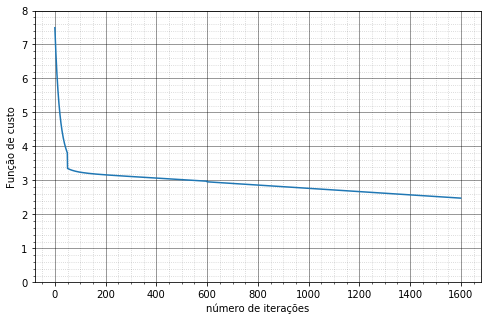

In [112]:
plt.figure(figsize=(8,5))
plt.plot(J)
plt.xlabel('número de iterações')
plt.ylim(0, 8)
plt.ylabel('Função de custo')
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=.5)
plt.grid(b=True, which='minor', color='k', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.savefig('J_grad_desc.png')
plt.show()

In [146]:
rede1.As = rede1.embrulha(rede1.pesos_iniciais)[0]
rede1.bs = rede1.embrulha(rede1.pesos_iniciais)[1]

performance_rede(rede1, treino)

percentual de acerto:  63.4
percentual de erro de cada algarismo:  [15.56291391  6.12244898 55.28169014 66.77966102 40.53156146 71.19205298
 16.1971831  30.03194888 33.5483871  31.11111111]
distribuicao de cada algarismo no espaço:  [10.06666667  9.8         9.46666667  9.83333333 10.03333333 10.06666667
  9.46666667 10.43333333 10.33333333 10.5       ]


(63.4, array([15.56291391,  6.12244898, 55.28169014, 66.77966102, 40.53156146,
        71.19205298, 16.1971831 , 30.03194888, 33.5483871 , 31.11111111]), array([10.06666667,  9.8       ,  9.46666667,  9.83333333, 10.03333333,
        10.06666667,  9.46666667, 10.43333333, 10.33333333, 10.5       ]))

1 1


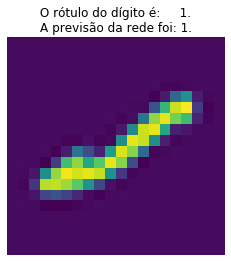

6 6


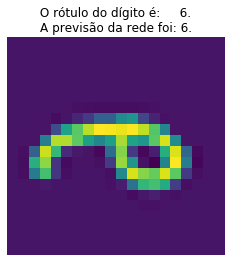

7 7


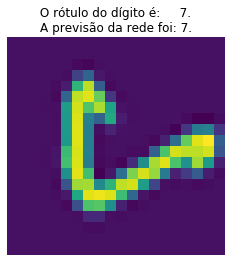

3 1


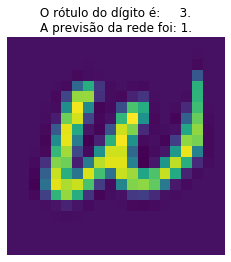

8 1


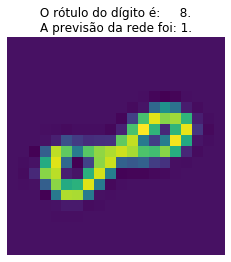

2 8


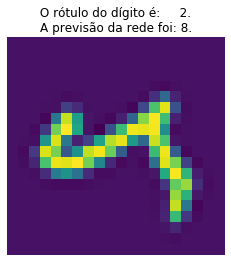

5 2


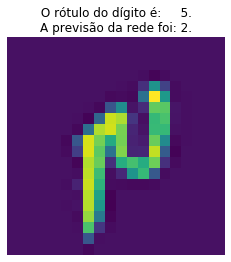

7 7


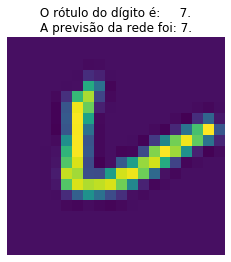

1 1


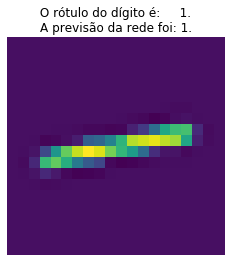

2 2


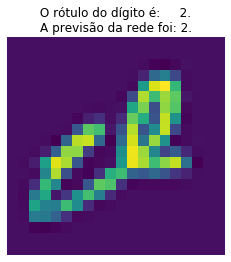

4 4


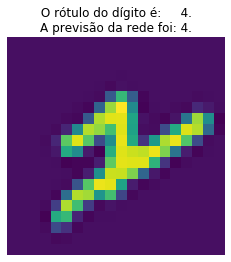

4 4


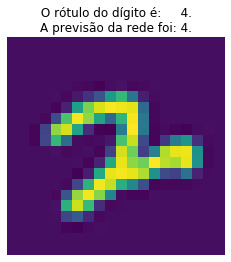

6 6


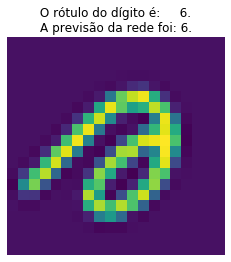

7 7


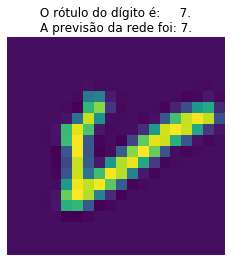

7 9


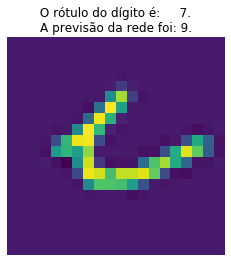

5 6


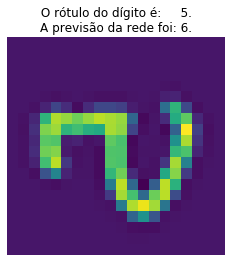

1 1


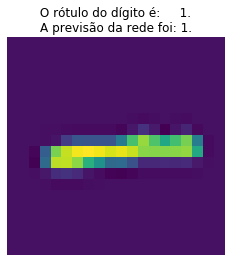

8 8


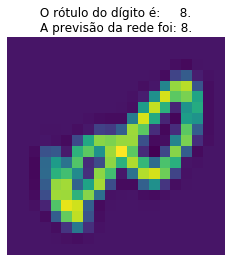

1 1


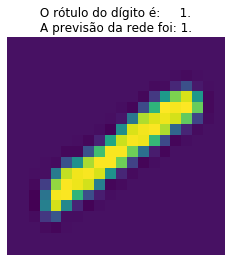

3 0


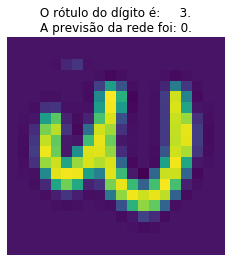

5 5


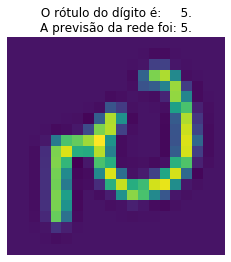

7 7


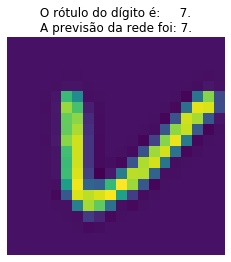

4 4


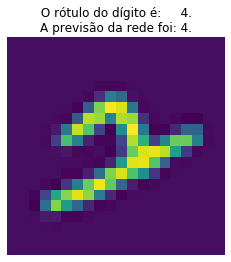

9 9


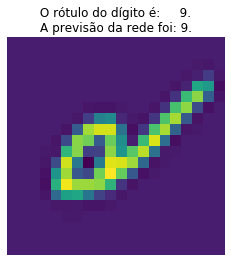

0 0


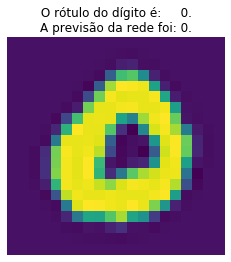

6 6


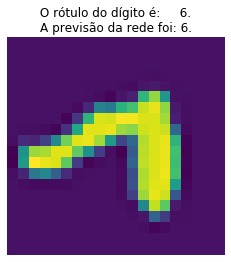

3 3


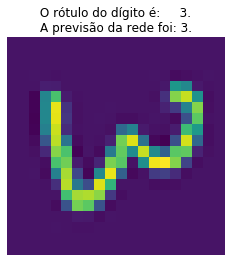

6 6


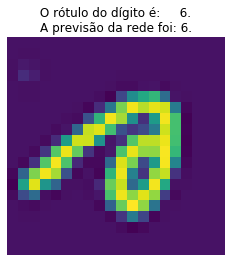

0 5


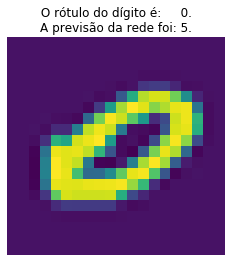

0 0


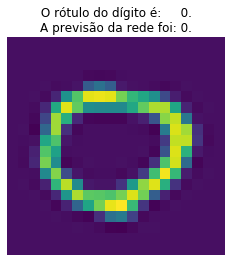

6 6


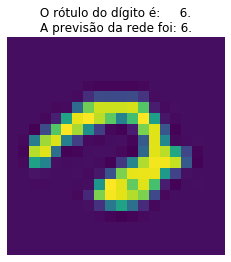

8 8


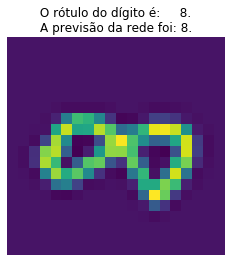

2 2


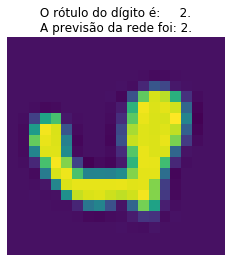

7 7


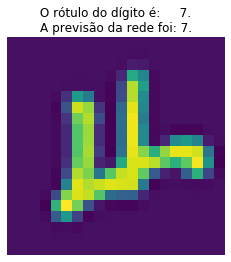

3 8


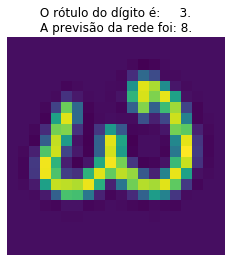

3 7


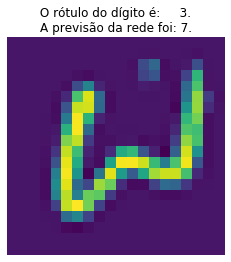

7 7


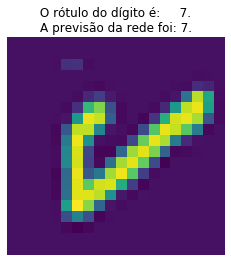

2 3


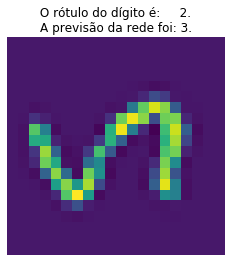

6 0


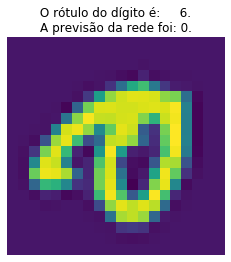

0 0


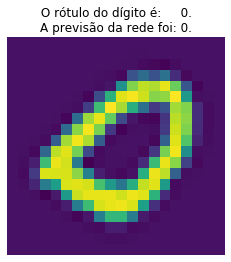

0 0


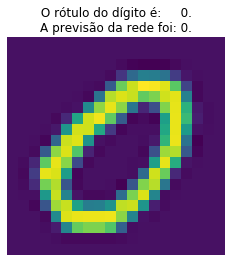

9 9


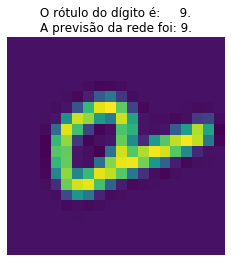

0 0


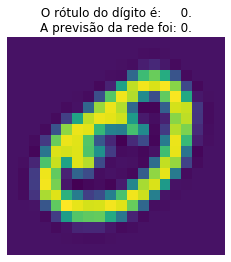

7 7


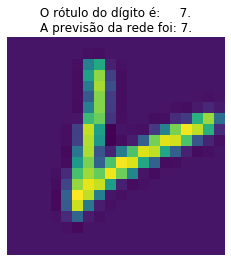

1 1


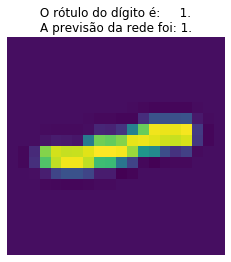

2 2


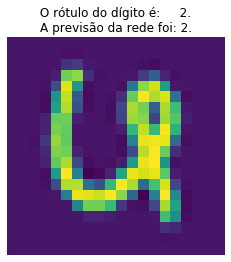

5 5


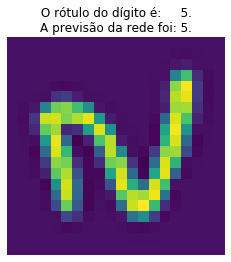

0 0


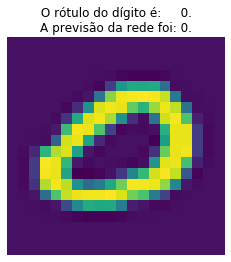

6 6


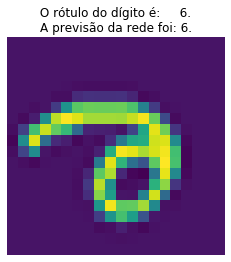

7 7


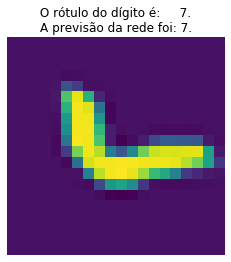

3 5


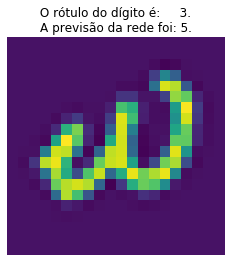

2 6


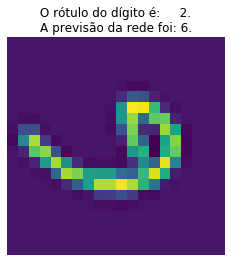

5 3


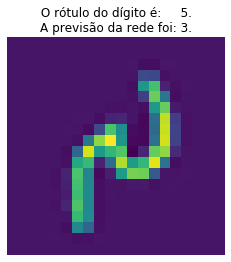

9 9


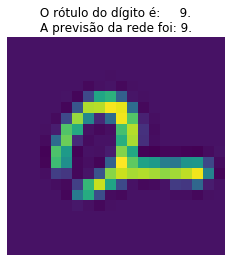

9 5


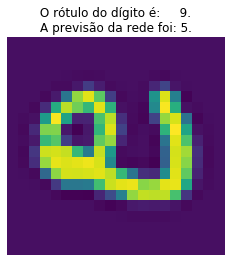

9 9


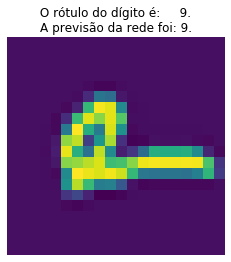

0 0


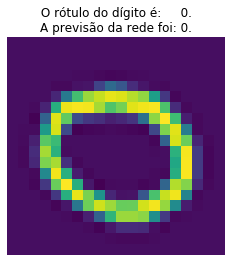

2 8


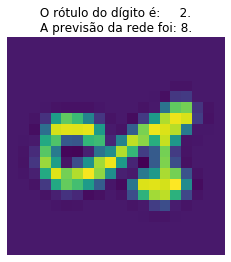

8 8


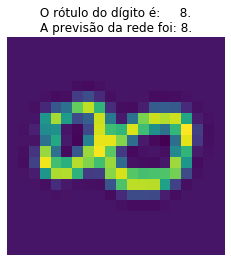

9 9


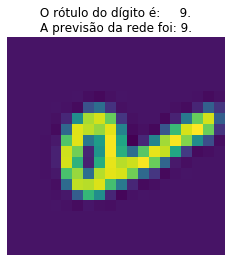

5 5


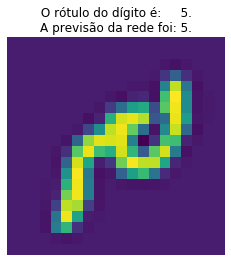

0 0


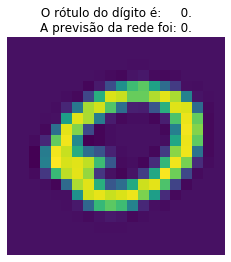

3 2


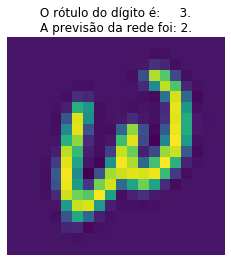

6 6


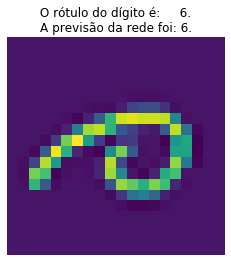

8 8


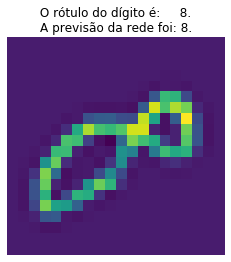

5 5


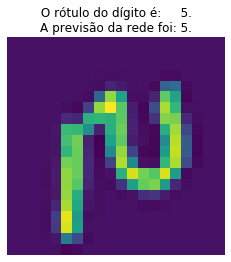

3 3


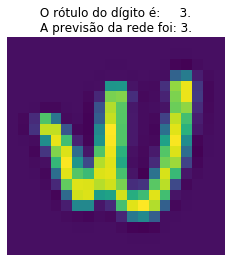

0 5


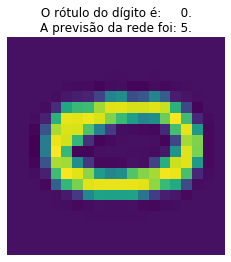

2 2


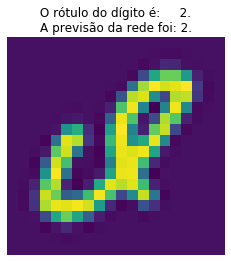

1 1


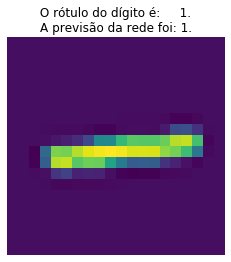

3 0


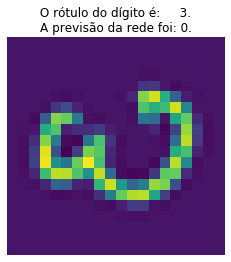

4 4


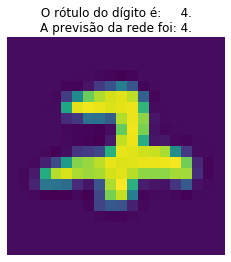

9 9


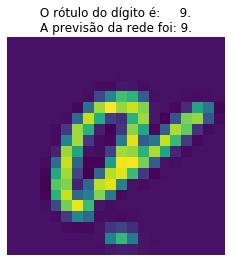

2 2


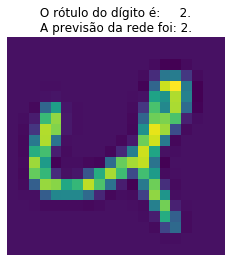

1 1


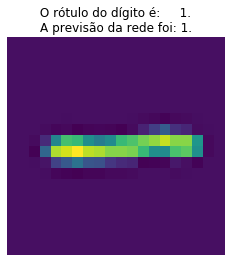

1 1


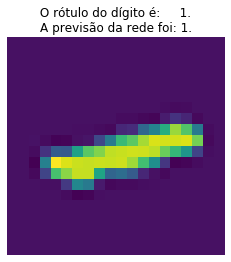

9 7


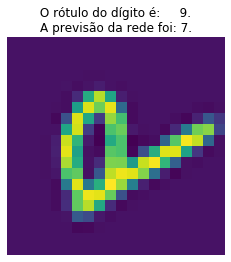

8 8


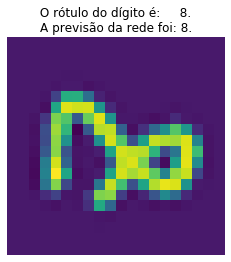

7 7


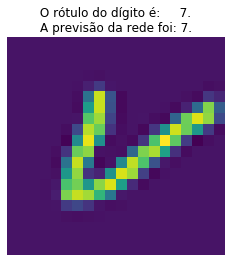

6 6


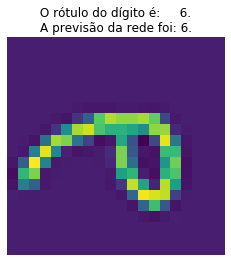

6 6


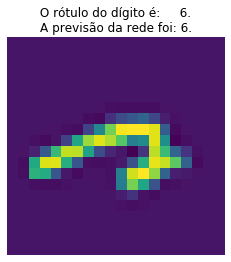

2 2


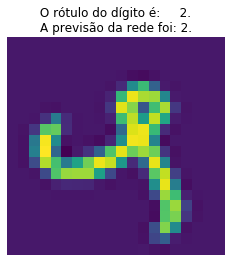

2 2


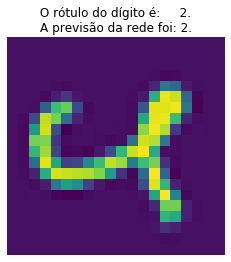

5 1


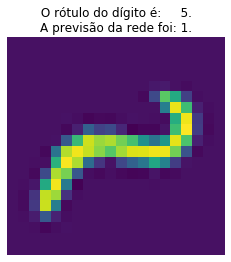

4 4


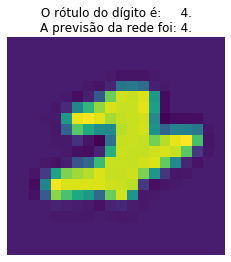

3 3


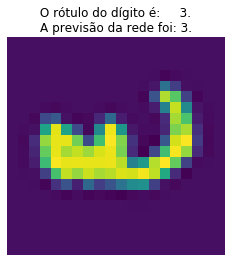

7 9


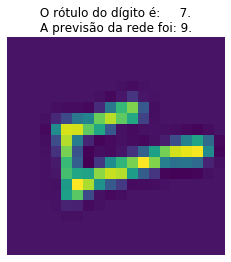

0 0


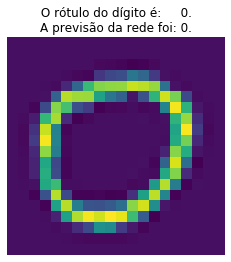

7 9


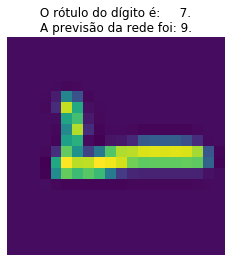

0 4


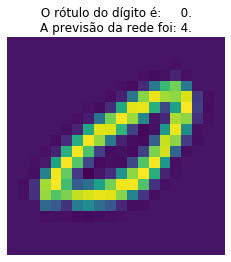

9 7


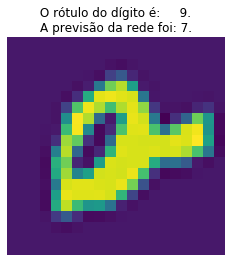

3 3


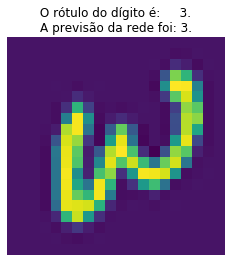

3 5


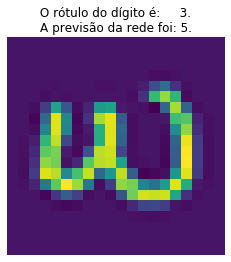

9 9


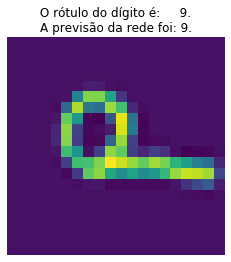

1 1


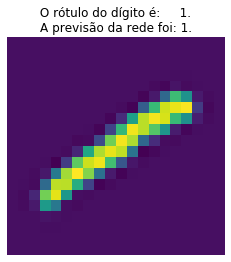

6 6


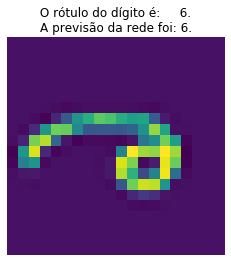

1 1


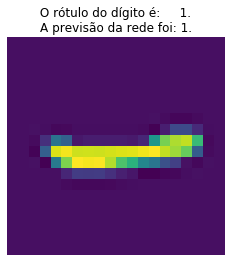

8 7


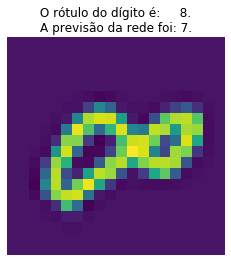

2 7


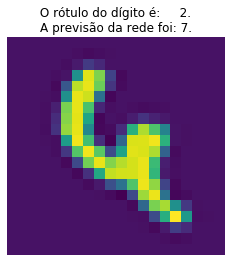

3 3


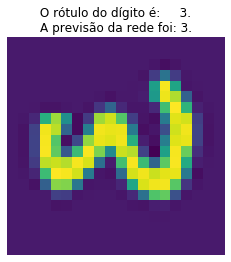

2 7


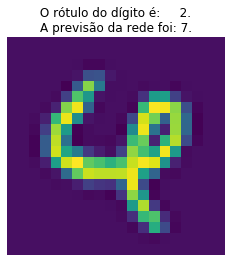

1 1


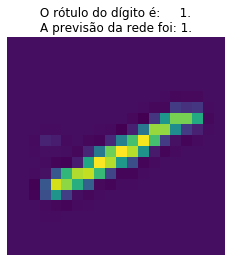

3 6


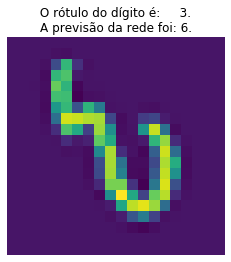

4 4


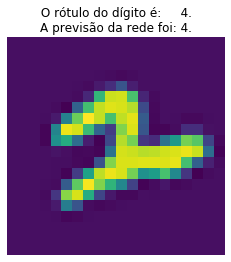

7 7


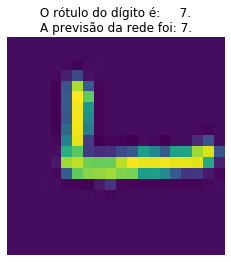

4 4


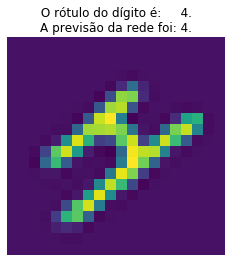

4 4


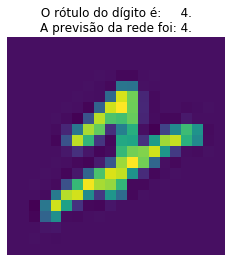

0 0


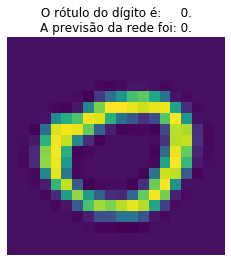

1 1


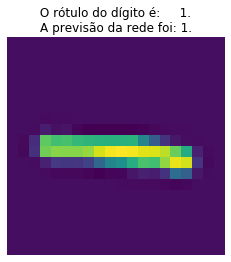

8 8


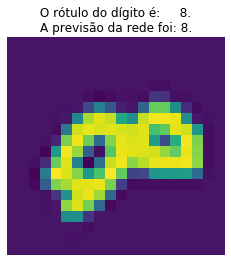

5 6


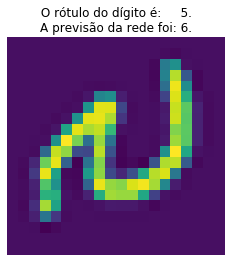

5 4


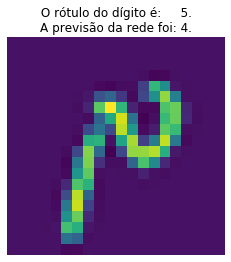

6 6


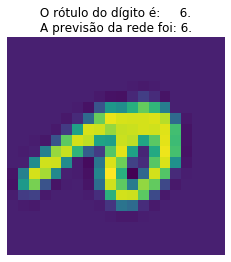

1 1


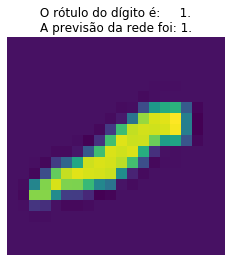

9 9


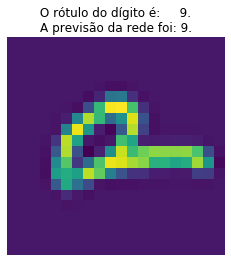

5 6


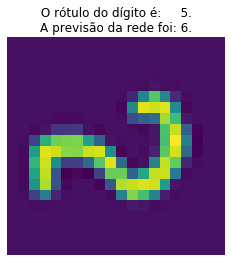

7 7


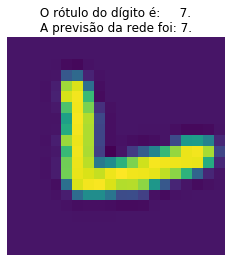

5 8


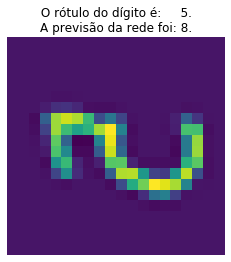

8 8


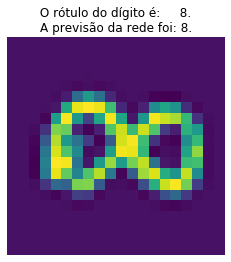

0 0


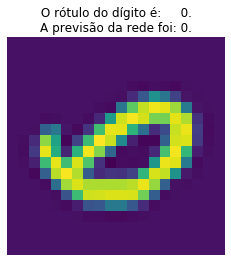

5 0


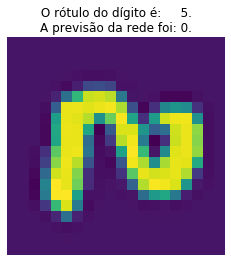

1 1


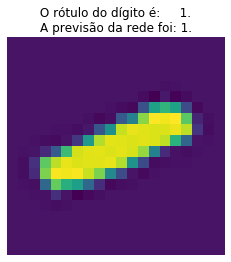

4 4


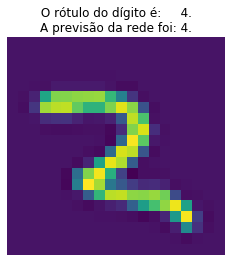

0 0


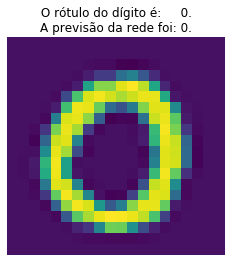

4 4


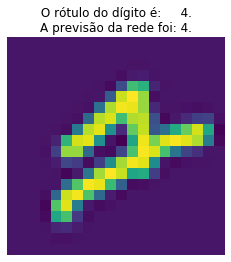

0 0


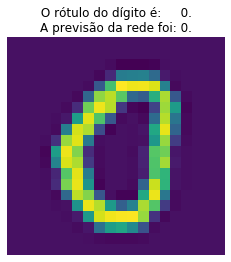

8 8


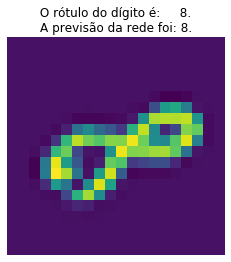

9 1


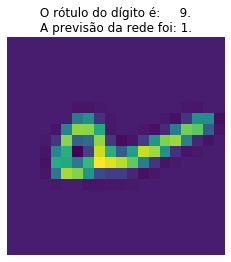

2 6


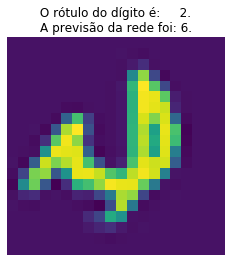

5 5


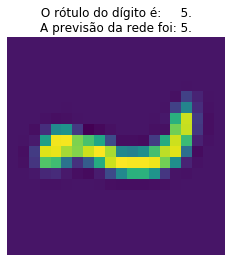

7 1


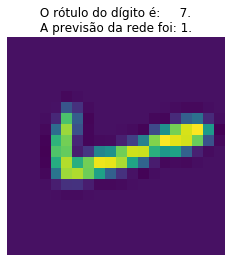

5 5


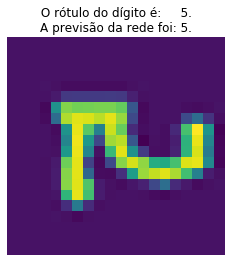

9 9


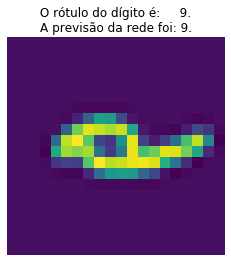

0 0


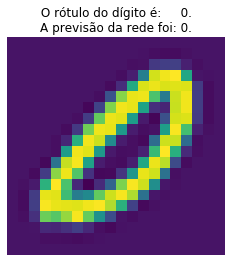

8 7


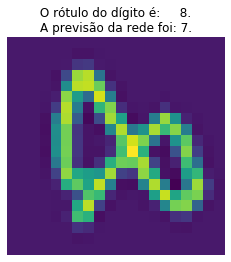

0 0


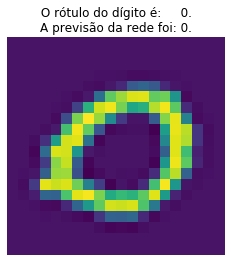

8 7


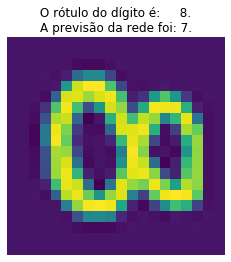

1 1


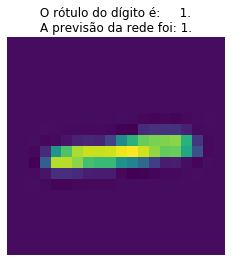

6 6


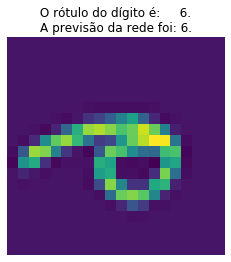

2 6


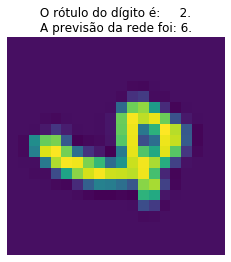

2 2


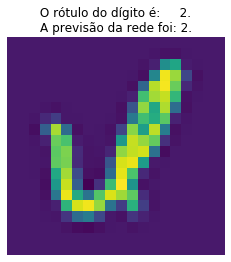

5 0


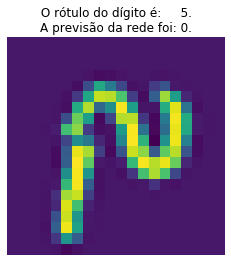

7 4


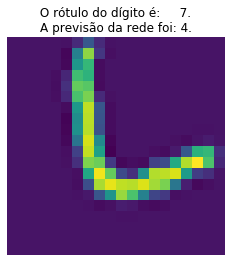

9 7


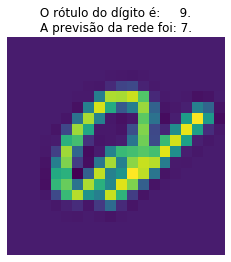

7 7


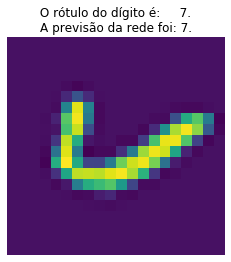

0 5


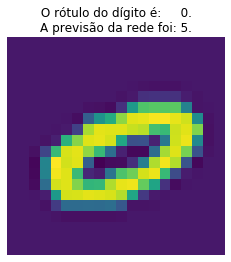

4 2


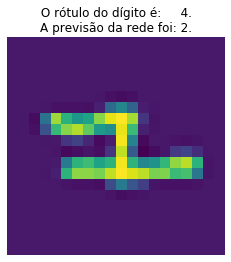

0 0


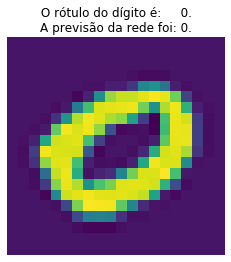

4 4


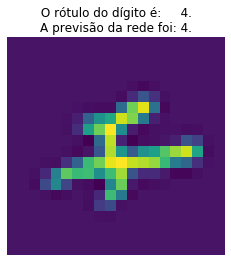

3 5


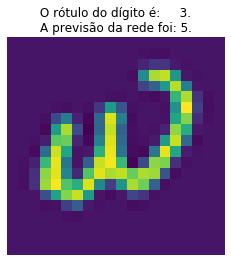

4 4


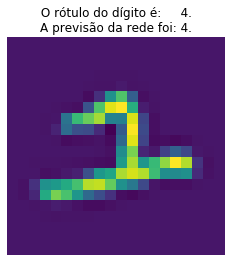

9 9


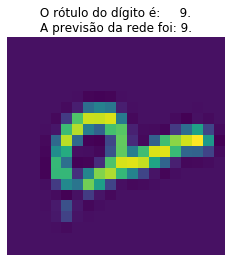

9 7


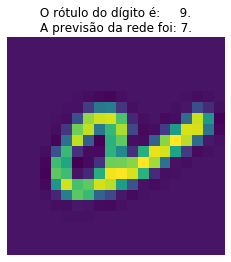

1 1


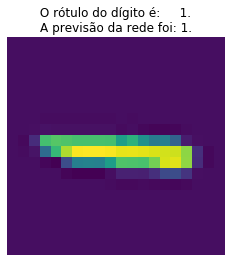

8 8


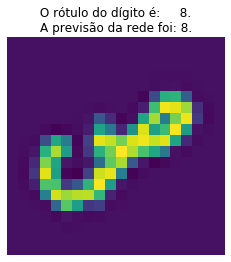

6 6


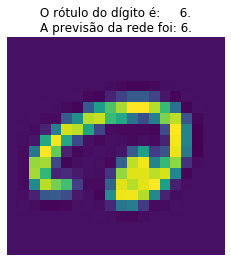

2 2


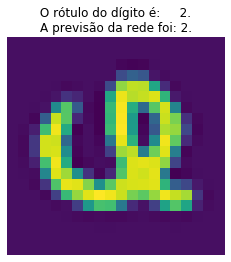

7 7


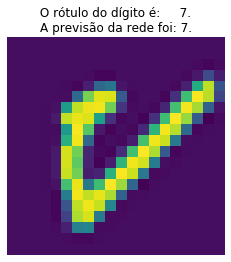

3 3


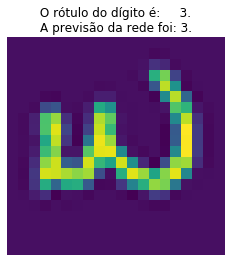

9 9


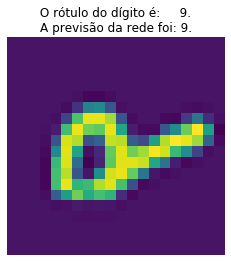

6 6


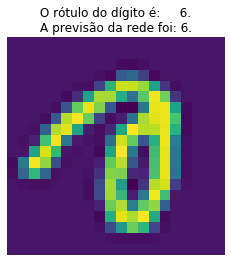

7 7


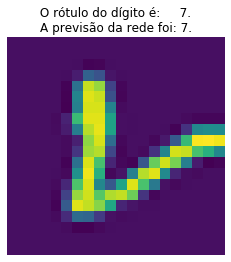

3 3


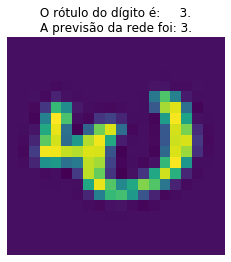

7 7


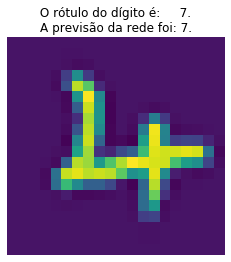

6 6


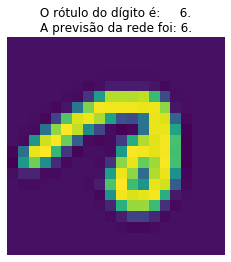

9 9


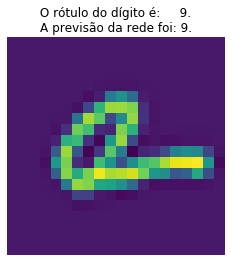

7 7


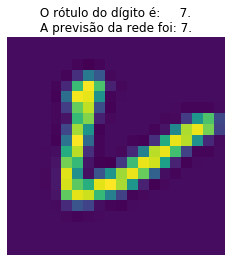

4 4


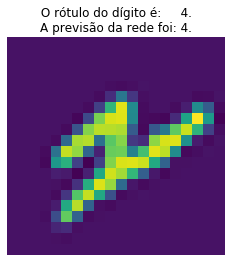

4 4


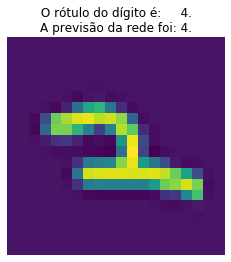

1 4


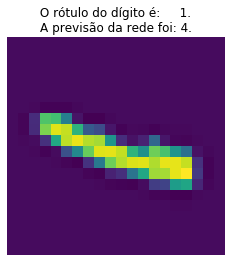

1 1


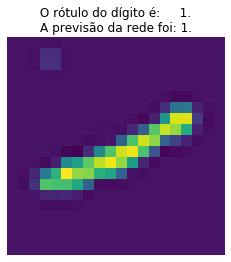

4 4


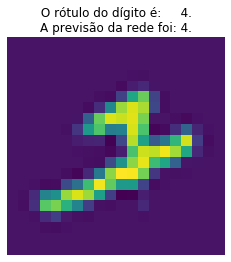

1 1


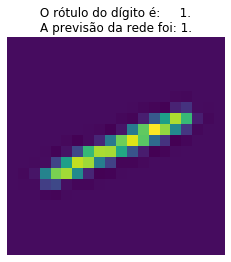

3 2


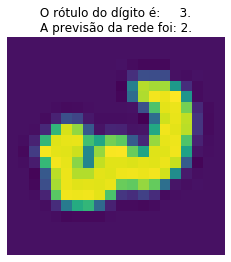

2 6


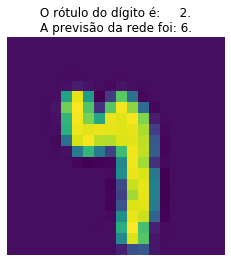

7 7


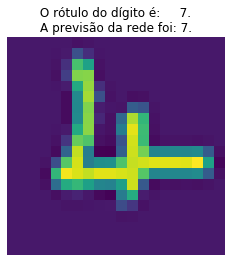

5 0


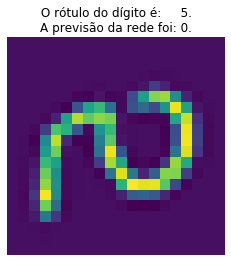

5 1


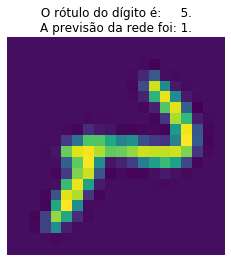

8 8


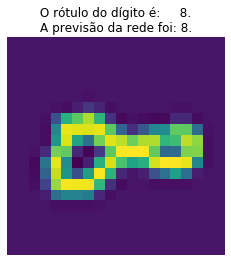

2 1


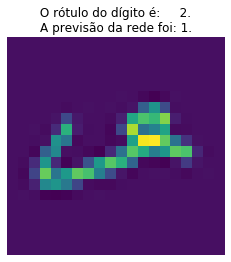

5 8


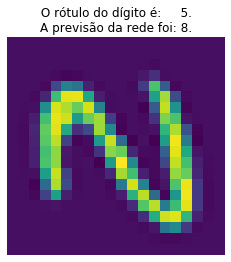

3 8


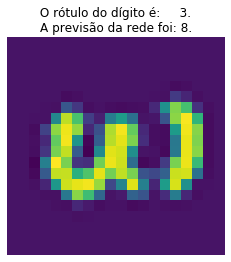

9 9


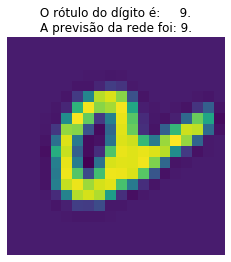

2 1


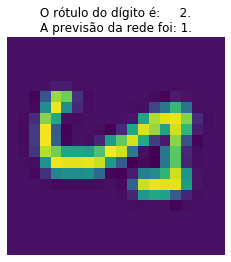

4 1


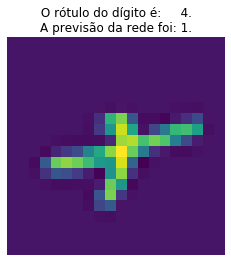

1 1


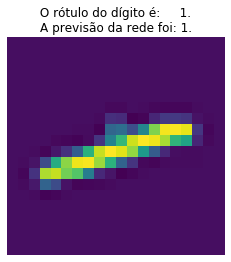

1 4


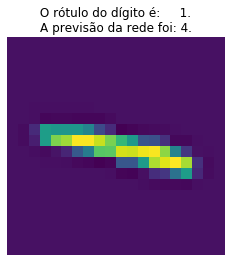

3 1


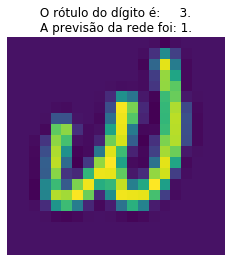

8 1


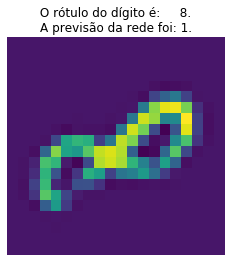

0 0


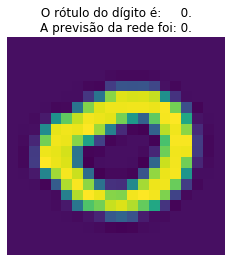

1 1


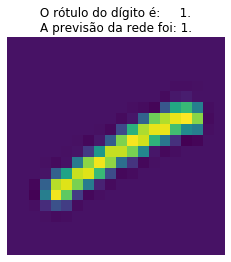

7 7


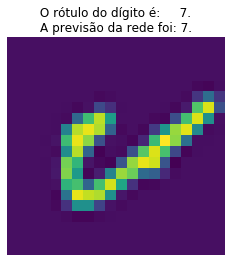

2 1


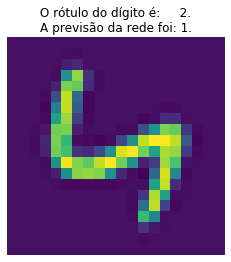

3 3


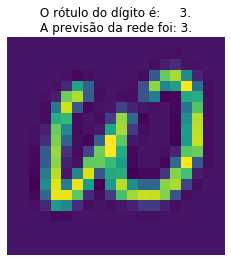

8 0


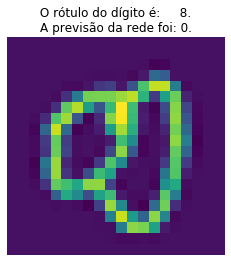

7 7


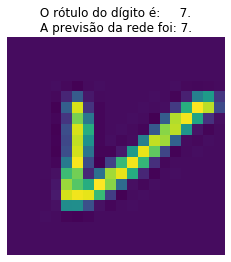

3 3


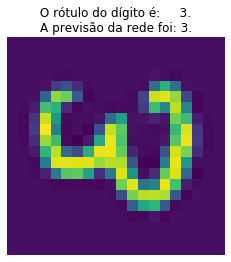

3 3


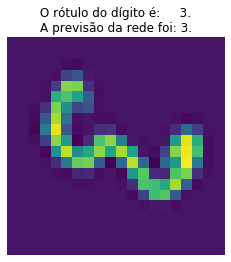

8 9


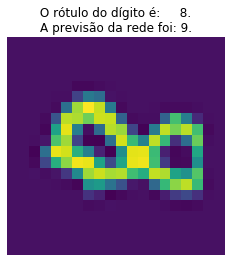

4 4


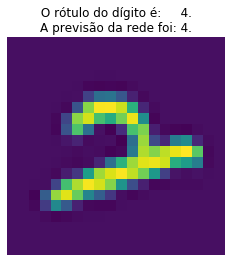

7 7


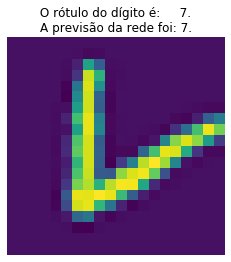

8 8


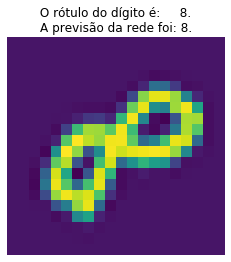

6 6


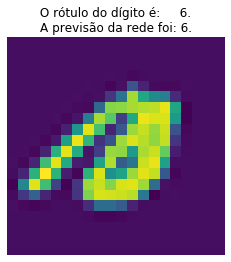

9 9


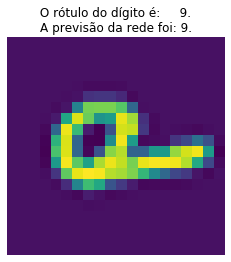

4 4


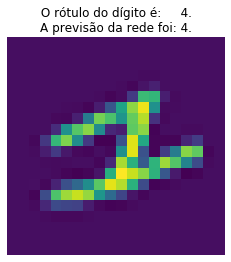

3 0


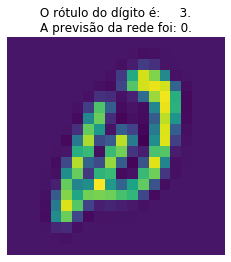

7 7


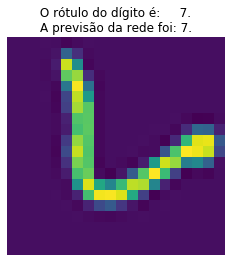

4 9


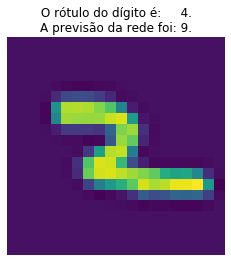

7 9


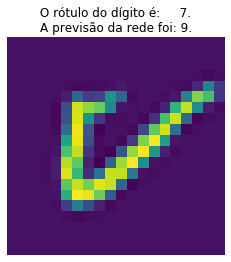

6 6


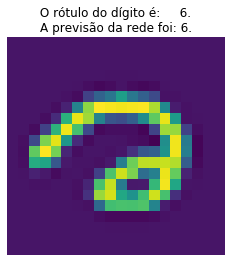

3 3


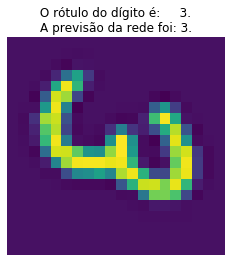

8 1


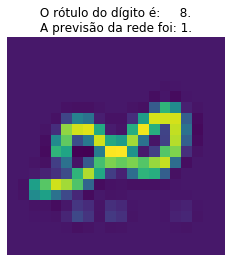

2 2


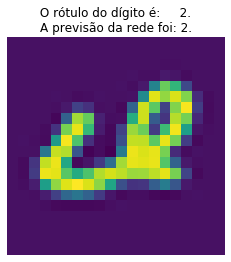

0 5


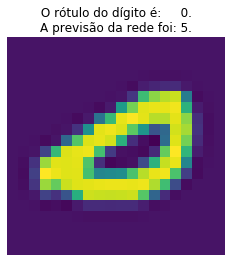

6 6


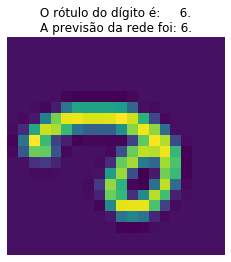

5 5


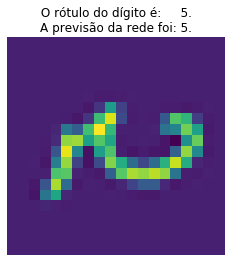

1 1


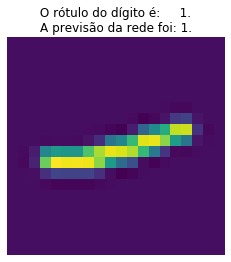

8 8


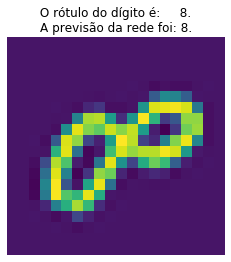

7 7


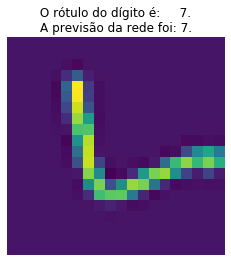

8 0


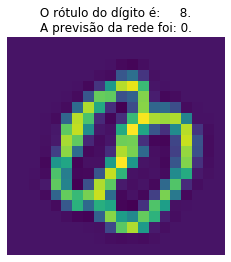

5 2


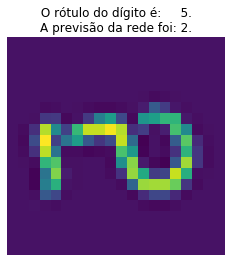

1 1


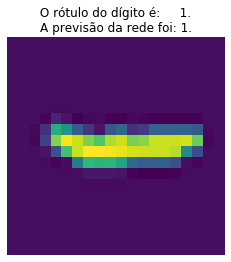

0 0


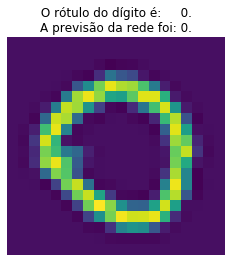

2 2


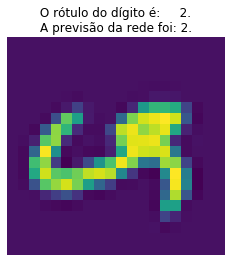

6 6


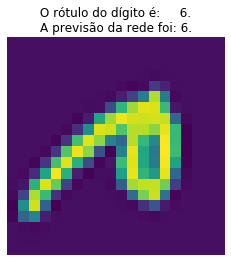

4 4


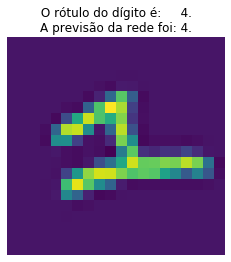

7 7


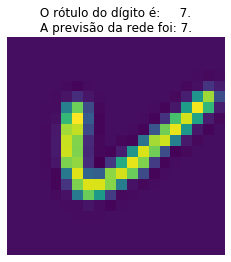

8 8


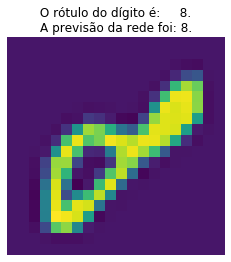

5 5


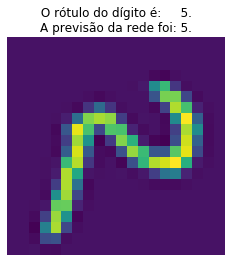

7 1


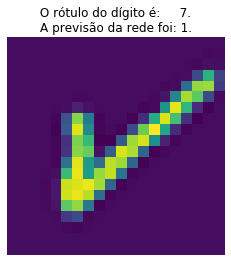

5 8


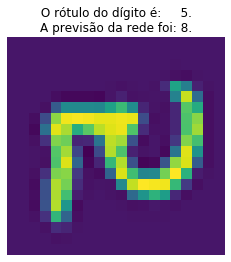

0 5


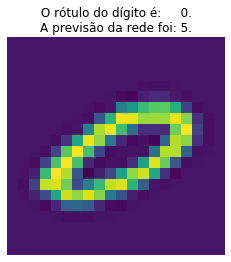

3 3


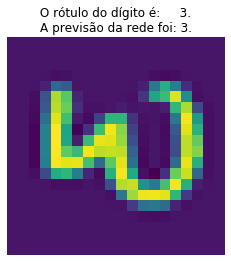

1 1


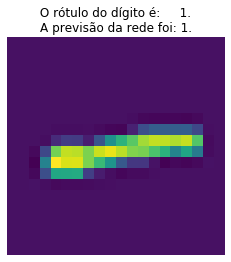

0 0


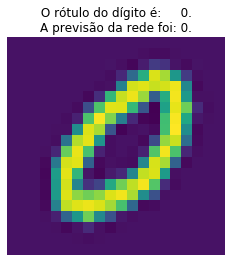

2 1


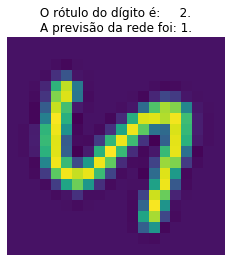

4 4


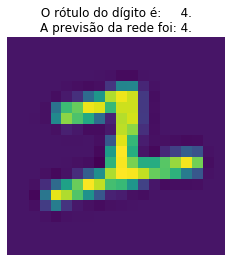

8 7


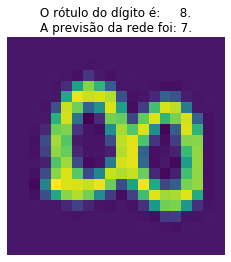

7 7


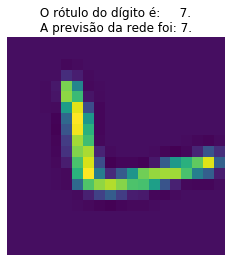

2 8


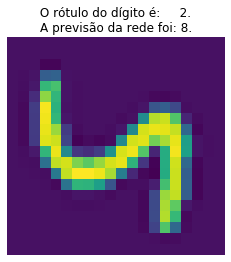

9 9


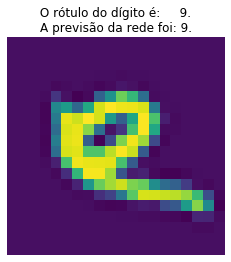

9 9


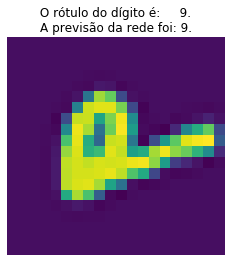

0 6


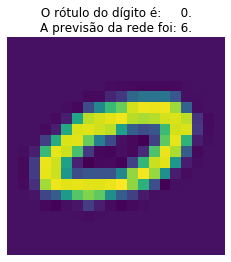

6 6


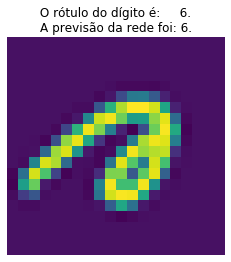

9 9


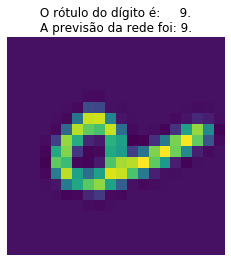

3 3


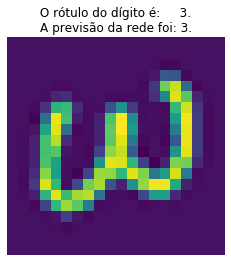

6 6


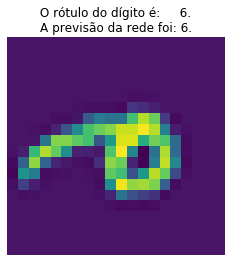

3 3


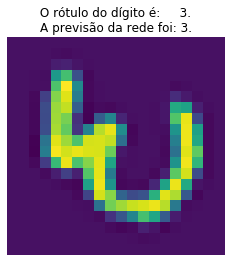

5 8


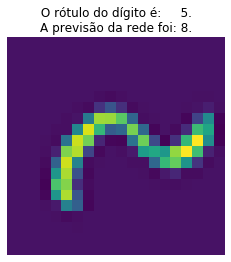

6 6


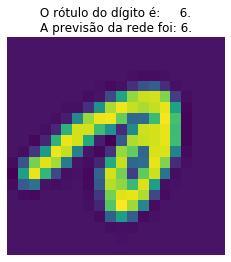

6 6


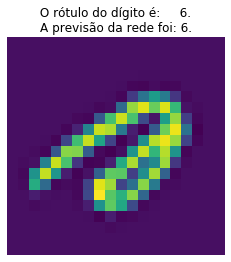

0 0


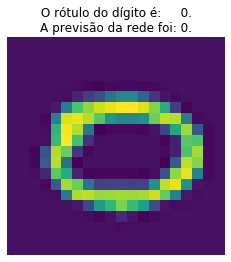

8 8


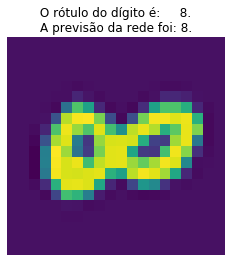

3 8


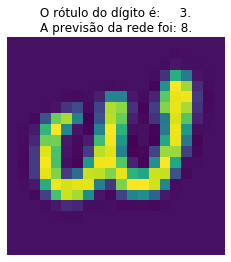

2 2


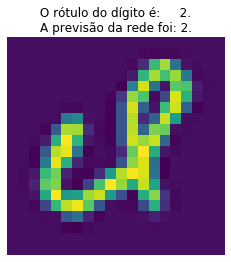

9 7


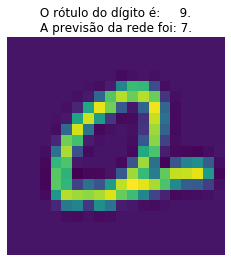

9 9


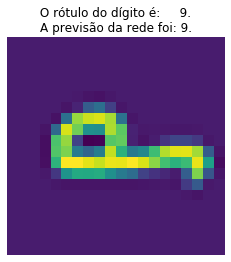

6 2


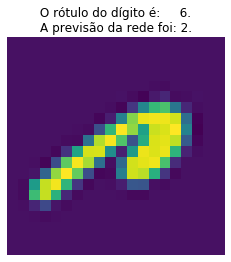

6 6


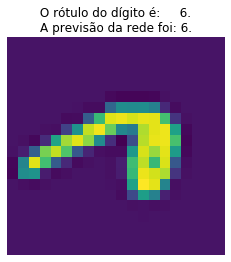

5 6


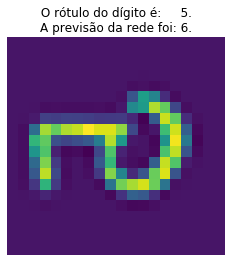

5 5


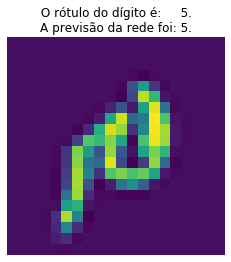

6 6


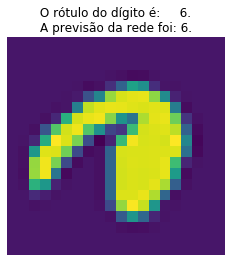

2 2


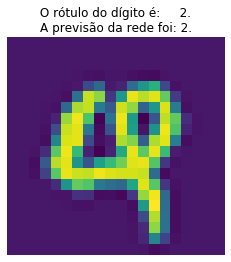

0 0


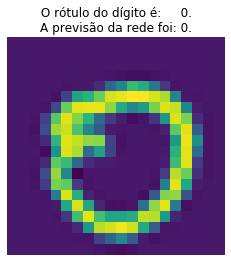

7 7


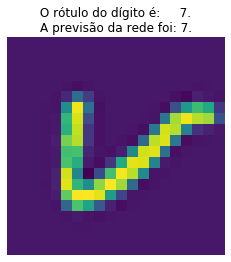

3 1


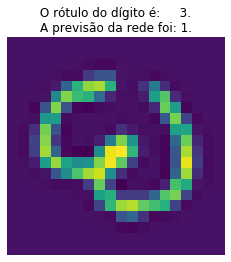

2 4


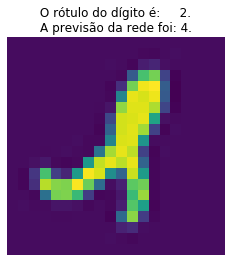

2 2


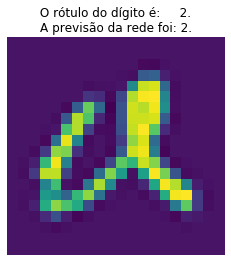

3 3


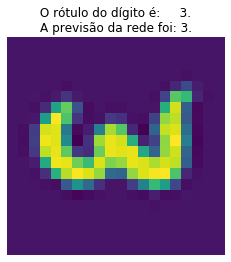

2 8


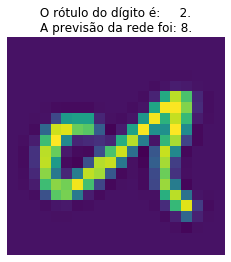

3 3


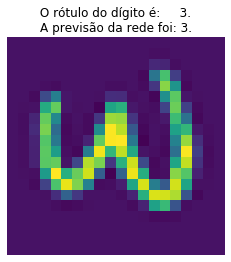

4 4


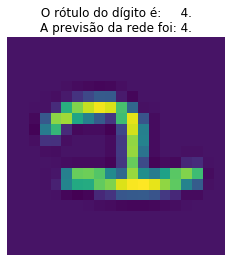

6 6


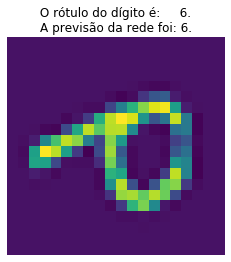

6 6


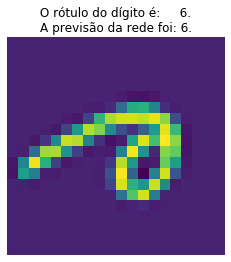

5 3


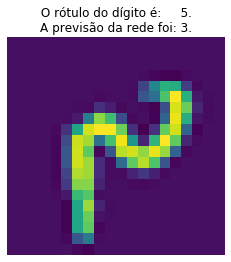

5 1


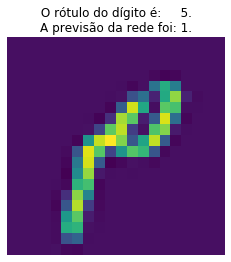

5 9


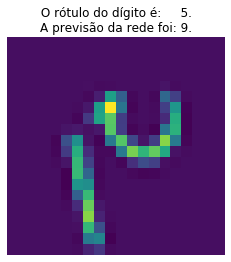

7 7


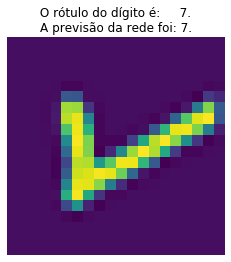

5 8


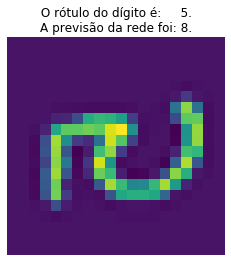

4 4


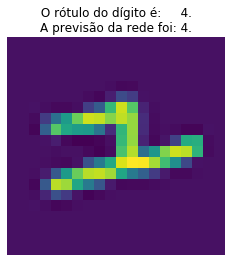

0 0


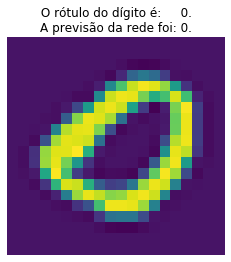

8 8


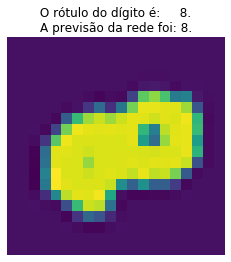

3 8


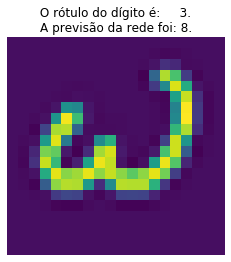

0 0


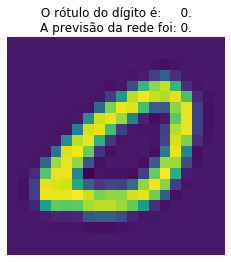

8 8


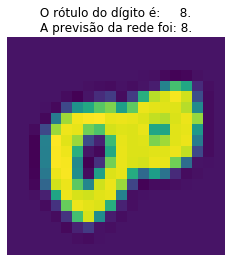

0 0


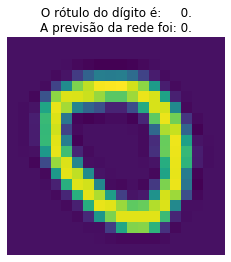

2 2


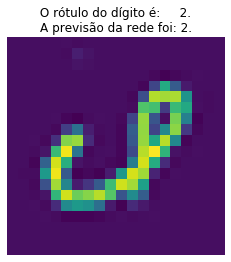

5 0


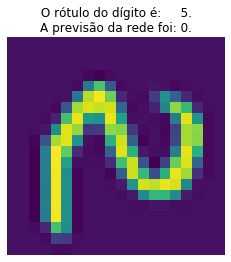

3 3


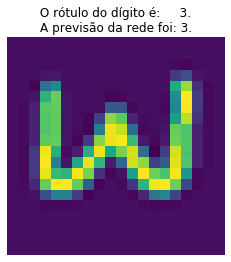

0 0


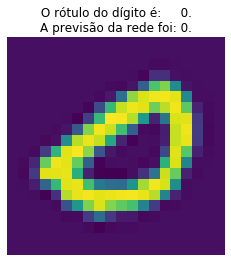

4 2


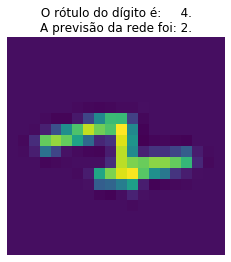

2 2


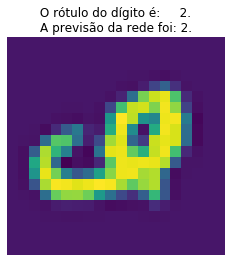

8 2


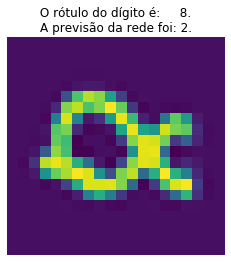

1 1


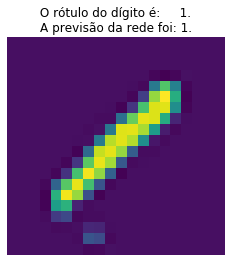

3 1


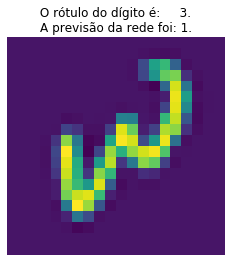

5 8


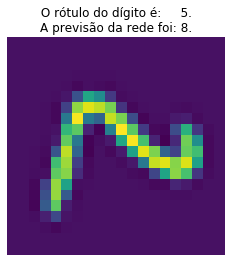

6 6


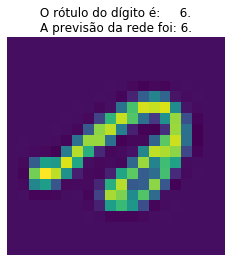

3 3


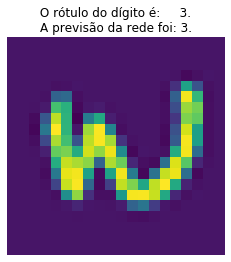

7 7


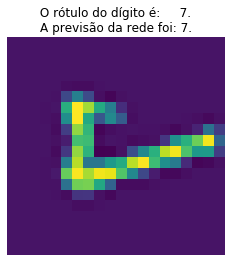

0 0


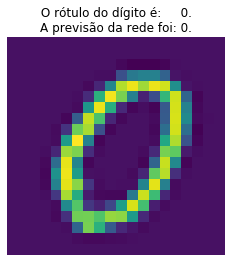

6 6


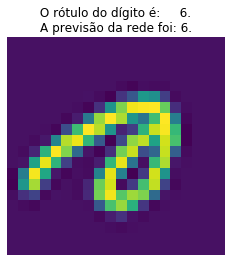

5 9


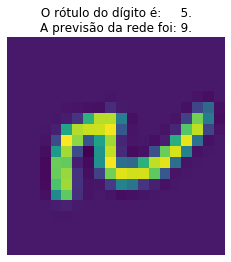

8 2


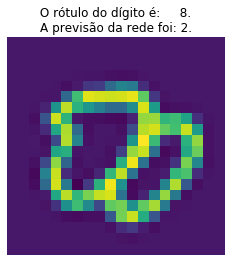

7 1


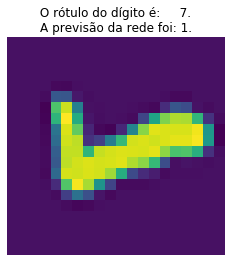

9 8


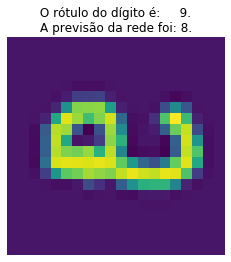

2 4


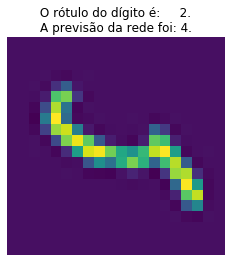

3 5


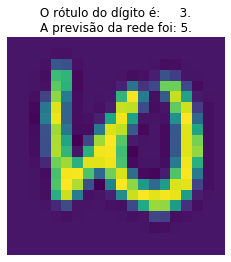

7 7


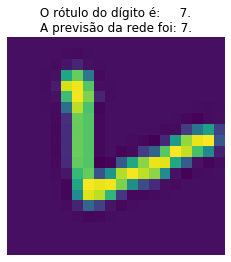

3 3


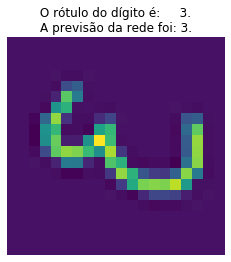

5 8


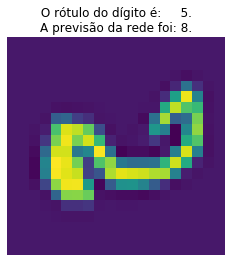

5 4


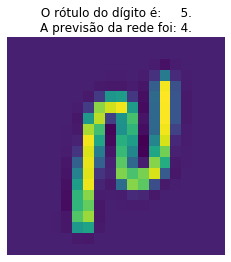

5 3


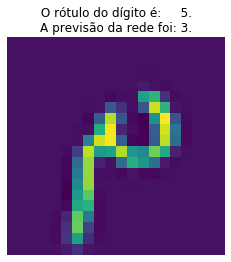

2 0


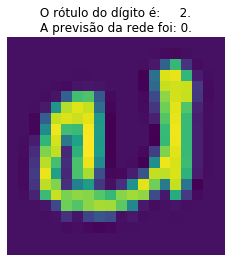

6 6


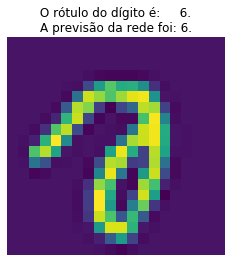

2 7


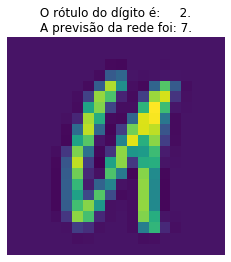

0 0


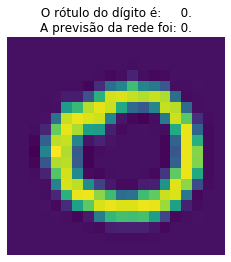

8 8


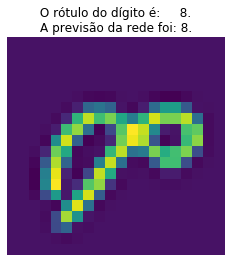

1 1


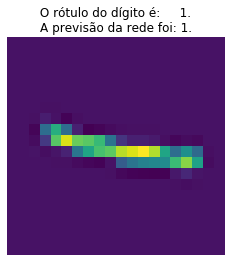

6 6


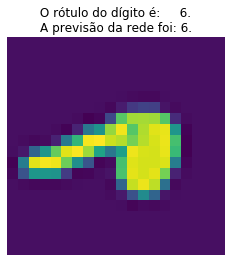

2 8


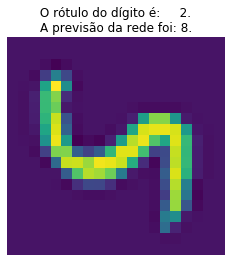

7 7


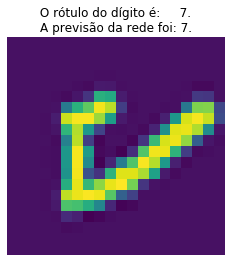

9 9


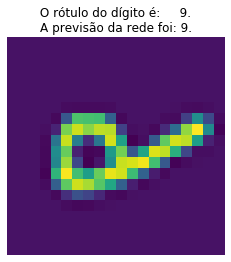

5 5


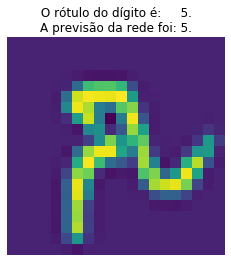

3 3


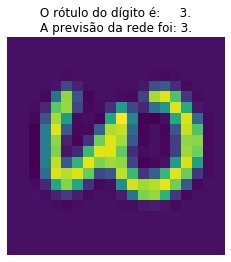

0 0


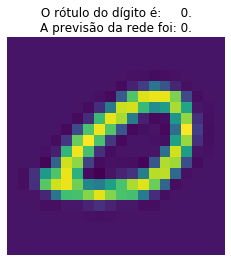

6 6


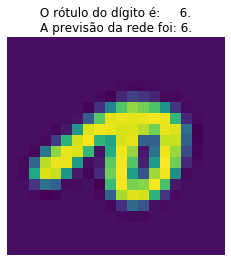

4 9


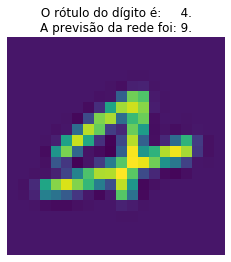

6 6


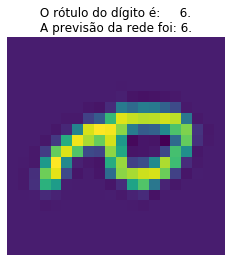

0 0


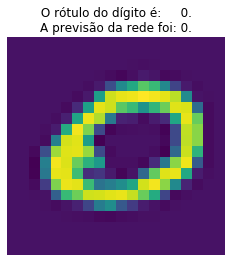

4 4


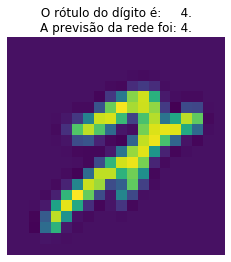

9 9


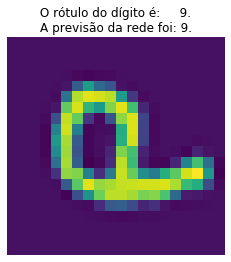

0 0


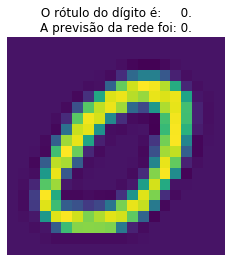

9 9


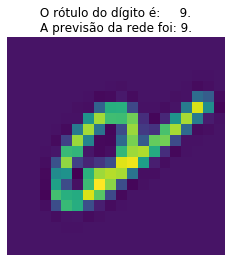

5 0


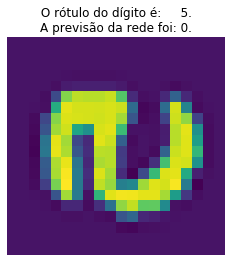

6 6


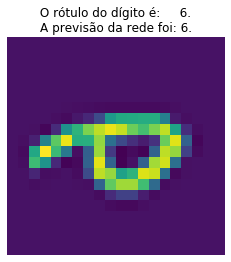

1 1


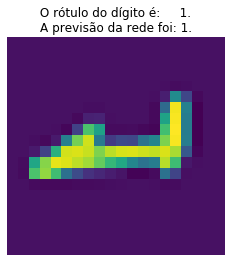

3 1


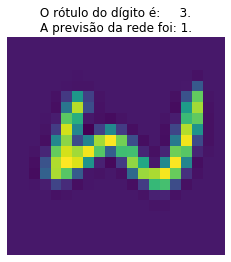

8 8


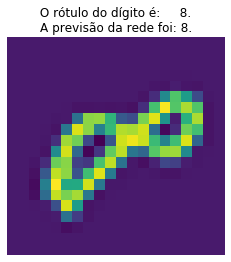

5 0


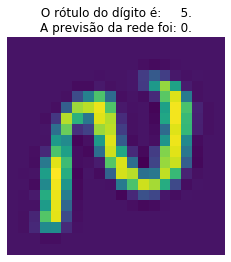

4 4


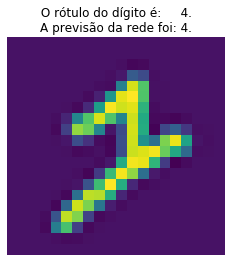

6 6


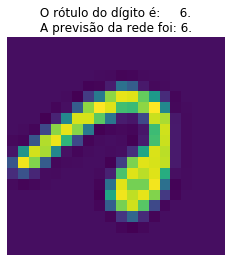

9 9


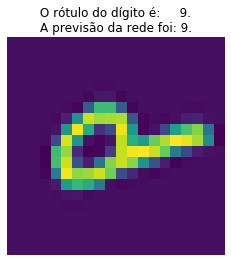

3 8


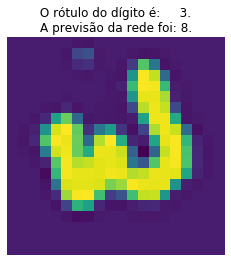

4 4


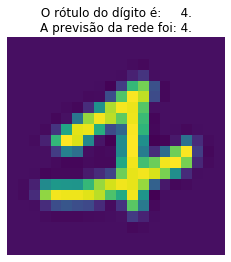

2 0


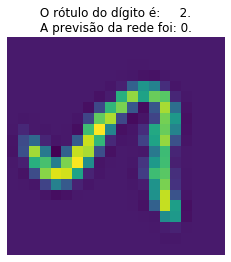

2 2


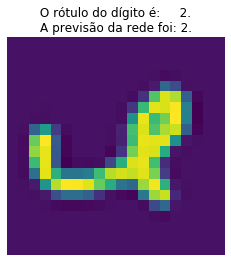

7 7


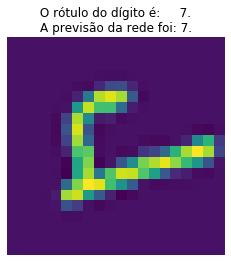

5 5


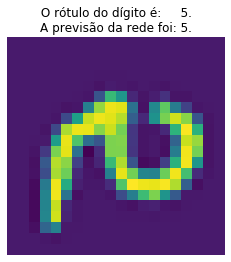

3 8


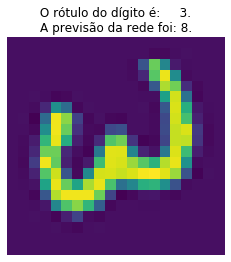

6 6


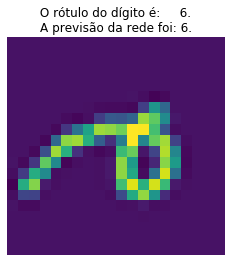

1 1


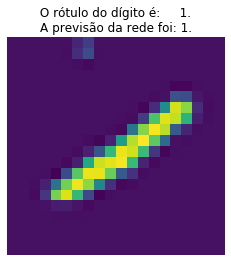

2 1


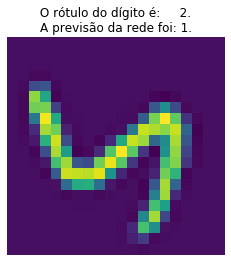

0 1


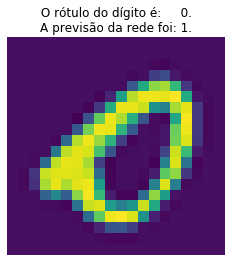

3 1


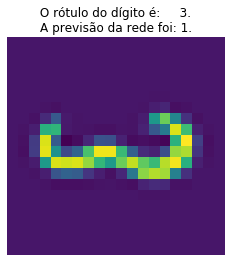

5 2


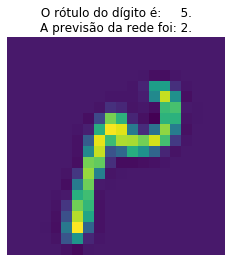

0 0


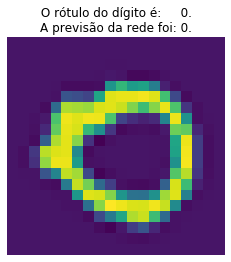

1 1


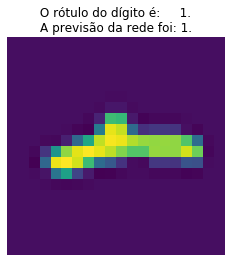

0 0


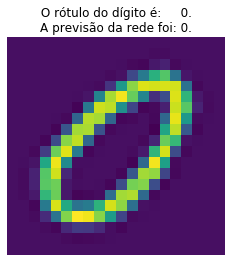

9 1


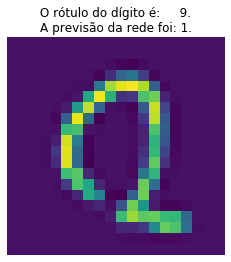

0 8


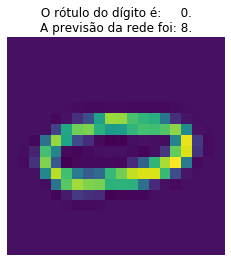

6 6


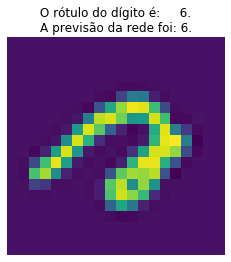

1 1


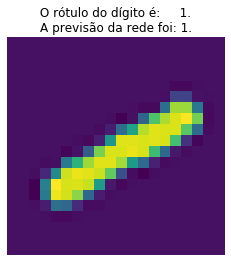

7 7


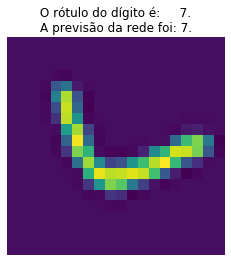

0 5


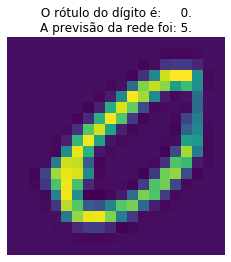

3 1


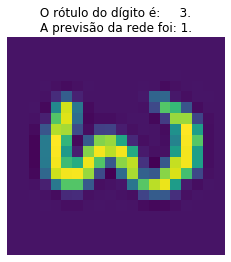

8 8


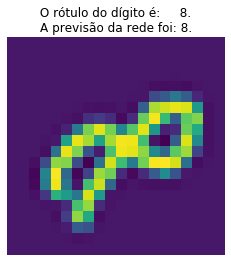

2 2


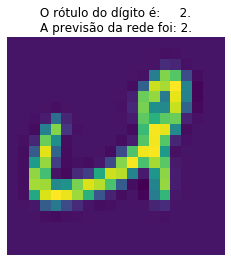

5 7


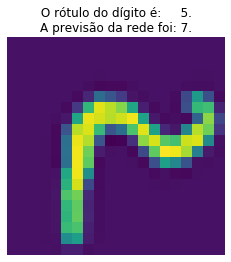

4 9


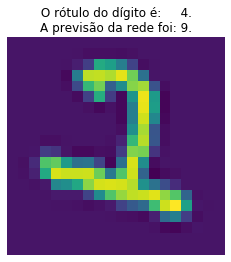

9 9


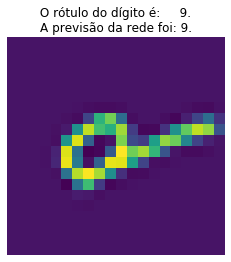

7 7


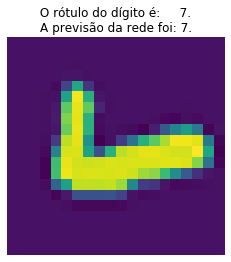

2 1


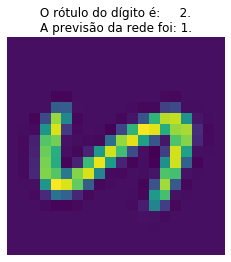

2 2


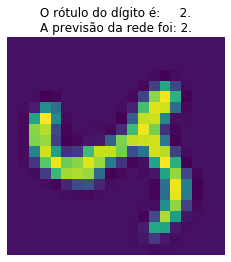

6 6


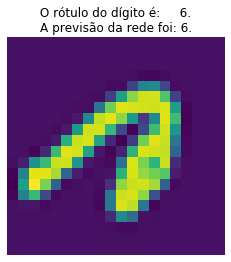

1 1


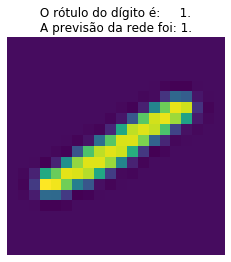

7 7


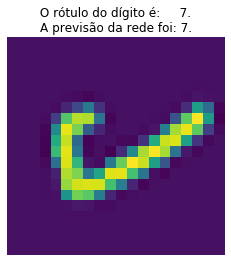

5 0


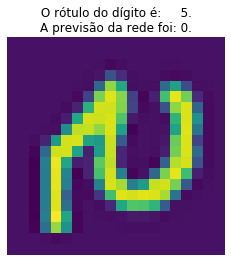

6 6


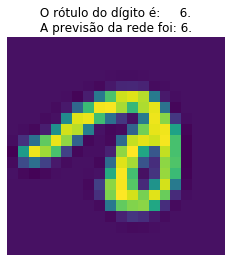

9 9


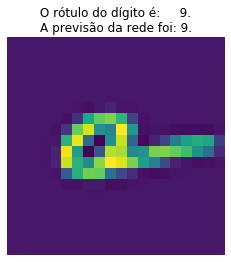

6 6


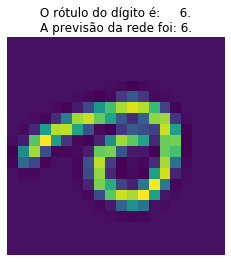

4 9


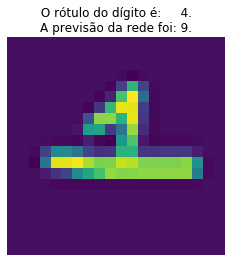

1 1


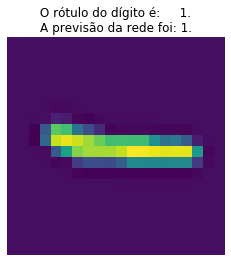

2 2


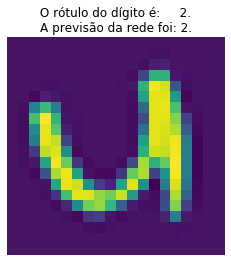

9 7


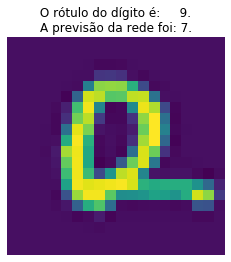

8 7


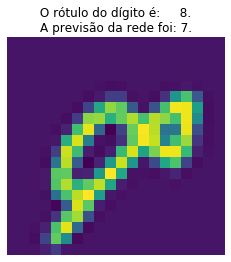

9 9


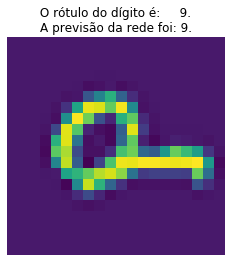

5 6


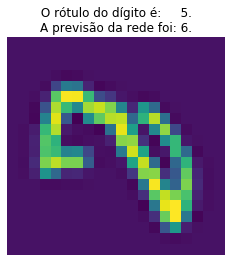

0 0


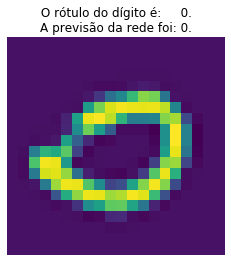

6 6


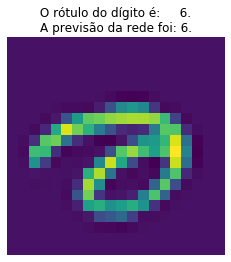

6 6


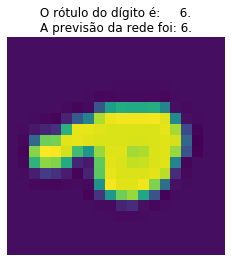

7 9


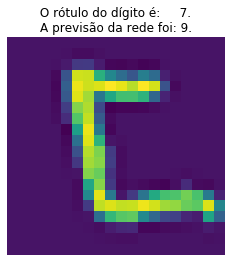

0 0


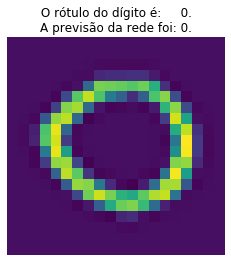

0 1


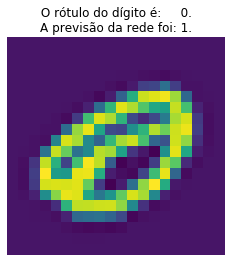

1 1


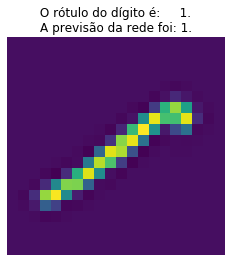

8 8


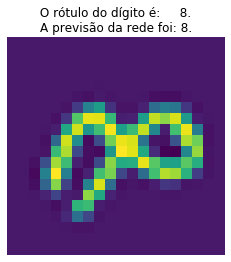

2 1


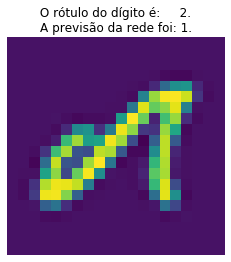

6 6


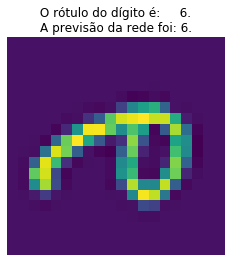

2 2


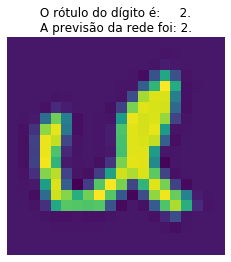

6 6


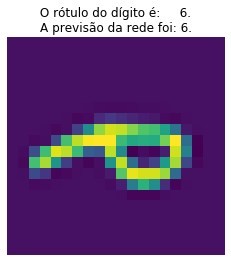

6 6


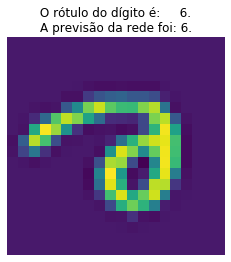

In [144]:
for i in range(400):
    print( teste[i].saida, np.argmax(rede1.sol(teste[i].entrada)))
    plt.imshow(teste[i].entrada.reshape((20,20)))
    plt.axis('off')
    plt.title(' O rótulo do dígito é:     '+str(teste[i].saida)+". \nA previsão da rede foi: "+str( np.argmax(rede1.sol(teste[i].entrada)) )+'.')
    plt.savefig('teste'+str(i)+'_sol_'+str(teste[i].saida)+'_resp_rede'+str(int( np.argmax(rede1.sol(teste[i].entrada)) ) )+'.png')
    plt.show()

## Inicializando a rede neural

3000


In [11]:
helpme = rede_neural(treino, [400, 25, 10], 0)
len(treino)
#helpme.num_vars

2498

In [130]:
from scipy.optimize import minimize
options = {'maxiter':20}
#sol = minimize(helpme.cost_fun, helpme.pesos_iniciais, options=options)
sol = minimize(helpme.cost_fun, helpme.pesos_iniciais, jac = helpme.grad_cost_fun, options=options)

217 0.09209316087773922
218 0.09179315251390978
219 0.0912556325465578
220 0.09047062040818397
221 0.09012010961769494
222 0.08990909871515278
223 0.08953960081668273
224 0.0889453782868112
225 0.08830015033371787
226 0.08794448212525727
227 0.08738306311233576
228 0.08670593144526166
229 0.08625331846995385
230 0.08578079829292419
231 0.08541975639768702
232 0.08498915104058906
233 0.08448082978010273
234 0.08399816447392106
235 0.08365404676341237
236 0.08336423191890878
237 0.08300275662608117


In [253]:
helpme.num_it = 0
pesos = helpme.pesos_iniciais

In [171]:
helpme.As = helpme.embrulha(sol['x'])[0]
helpme.bs = helpme.embrulha(sol['x'])[1]

In [15]:

    
def performance_rede(rede_neural, espaco_amostral_para_teste):
    espaco = espaco_amostral_para_teste
    rede = rede_neural
    cont_acertos = 0
    erros = np.zeros(10)
    cont_alg = np.zeros(10)
    for k in range(len(espaco)):
        x = espaco[k].entrada
        for A, b in zip(rede.As, rede.bs):
            x = sig( x@A + b ) 
        if np.argmax(x) == espaco[k].saida:
            cont_acertos +=1
        else:
            erros[espaco[k].saida] += 1
        cont_alg[espaco[k].saida] += 1
        
    distrib_por_alg_no_espaco = 100*cont_alg/len(espaco)
    taxa_acerto = cont_acertos/len(espaco)*100
    erro_por_algarismo = erros/cont_alg*100
    print("percentual de acerto: ", taxa_acerto)
    print("percentual de erro de cada algarismo: ", erro_por_algarismo)
    print("distribuicao de cada algarismo no espaço: ", distrib_por_alg_no_espaco)
    return taxa_acerto, erro_por_algarismo, distrib_por_alg_no_espaco
    
#performance_rede(helpme, teste)

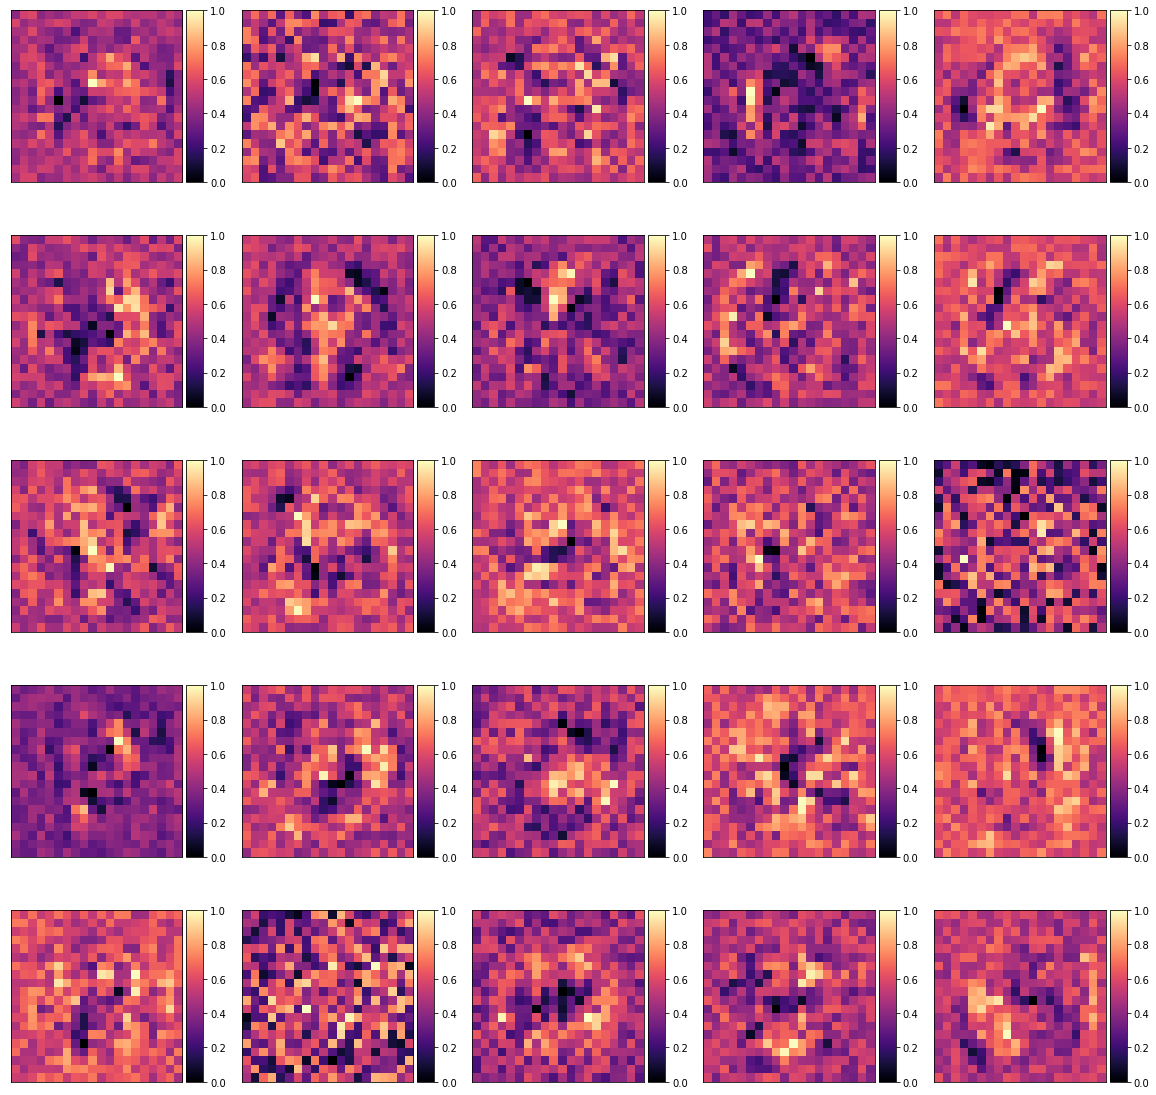

In [175]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots( 5, 5, figsize = (20, 20))  # para representar a ativacao dos 25 neuronios da camada escondida em funcao da img de entrada
neuros_camada_escondida = np.arange(25)
for (i, img_ativacao) in enumerate(helpme.As[0].T[neuros_camada_escondida]):
    img_ativacao = (img_ativacao - np.min(img_ativacao) ) / (np.max(img_ativacao) - np.min(img_ativacao))  # scaling os pesos
    im = axs[int(i/5)][i%5].imshow(img_ativacao.reshape(20, 20), cmap = 'magma')
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)
    # Create divider for existing axes instance
    divider = make_axes_locatable(axs[int(i/5)][i%5])
    # Append axes to the right of ax, with 10% width of ax
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.2), format="%.1f")
plt.savefig("camada_escondida.png")
plt.show()


In [18]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Curva de aprendizado (percentual de acerto vs num. de exemplos de treino)
tempo estimado para rodar: 32 horas

0 1000
O numero de exemplos para treino é  998 .
O numero de exemplos para teste é  4001 .
1 10.352224947423052
2 10.352224947423052
3 6.126070633857624
4 3.361492959891693
5 3.2373383690045614
6 3.109464055976478
7 2.969737313467177
8 2.722478541594284
9 2.337099042896684
10 2.0040566881427644
11 1.8322808626748903
12 1.6826607109192855
13 1.5528321960969529
14 1.4340236660763674
15 1.341442716502765
16 1.265929894194954
17 1.1762617938182285
18 1.0719856241032
19 0.9832722497327153
20 0.9337214738387406
21 0.8605466262630518
22 0.7966807013322146
23 0.7264363323559614
24 0.6700194720553633
25 0.6389911070699144
26 0.6074698401776435
27 0.5744356380159578
28 0.5405655898062247
29 0.5078425338356035
30 0.4751609243708421
31 0.45174115728720565
32 0.4324018444723196
33 0.4113004490718947
34 0.3992830841067653
35 0.3805146521074281
36 0.3576864884255264
37 0.3393027380373885
38 0.3199850090938473
39 0.3031589874495593
40 0.2907596714151467
41 0.2755035912098437
42 0.25876841314880156
43 

percentual de acerto:  88.00324236692786
percentual de erro de cada algarismo:  [ 6.95187166  3.51351351 13.94101877 15.57377049 14.4772118  17.45152355
  8.24175824  9.81432361 17.98365123 12.23404255]
distribuicao de cada algarismo no espaço:  [10.10537693  9.99729803 10.0783572   9.88921913 10.0783572   9.75412051
  9.83517968 10.1864361   9.91623885 10.15941637]
percentual de acerto:  98.15100154083206
percentual de erro de cada algarismo:  [0.         1.53846154 2.36220472 2.2556391  0.         2.15827338
 1.47058824 2.43902439 3.0075188  3.22580645]
distribuicao de cada algarismo no espaço:  [ 9.70724191 10.01540832  9.78428351 10.24653313  9.78428351 10.70878274
 10.47765794  9.4761171  10.24653313  9.55315871]
percentual de acerto:  88.00324236692786
percentual de erro de cada algarismo:  [ 6.95187166  3.51351351 13.94101877 15.57377049 14.4772118  17.45152355
  8.24175824  9.81432361 17.98365123 12.23404255]
distribuicao de cada algarismo no espaço:  [10.10537693  9.99729803 1

3 5.1553129346887205
4 3.3415049020216445
5 3.249264022517714
6 3.109083003499768
7 2.8883928909638956
8 2.5514437150697367
9 2.1989626025027835
10 2.0083417119681264
11 1.8614080928236039
12 1.6939677279006702
13 1.5294907490794305
14 1.4235132776713701
15 1.3412385805948077
16 1.268269601590534
17 1.189154617503647
18 1.122584421792717
19 1.0726848567611362
20 1.0020208961349173
21 0.9508439060508675
22 0.8926800328841785
23 0.8194043533502021
24 0.7497049679833538
25 0.7081486420091474
26 0.6775089575542963
27 0.6473307186115875
28 0.6181775863265057
29 0.5928372267524655
30 0.5742760279311581
31 0.5583267043891534
32 0.5345898555782426
33 0.5108858499578146
34 0.4911111893179883
35 0.470042191034009
36 0.45613888571427236
37 0.4423470220435909
38 0.4269450520145025
39 0.4102368394501003
40 0.3945049882718568
41 0.3799421804365476
42 0.36424955256268865
43 0.35019897051967247
44 0.3365215235480141
45 0.32386801000038296
46 0.31355689841499423
47 0.3057910551057801
48 0.2977858779028

ValueError: x and y must have same first dimension, but have shapes (20,) and (11,)

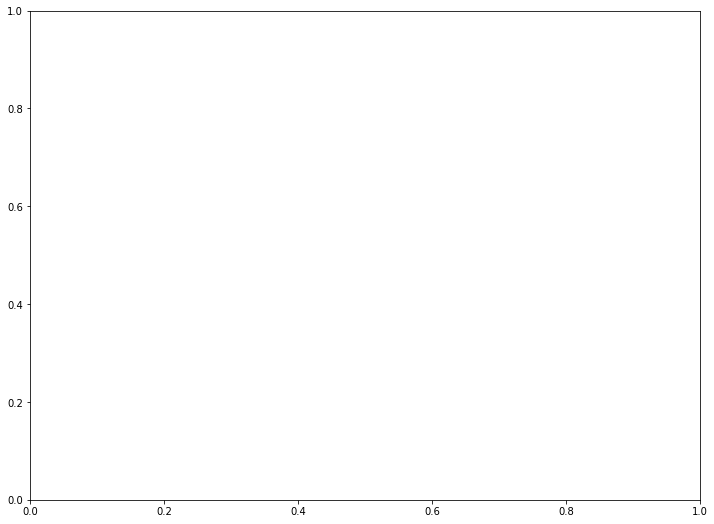

In [23]:
n_ex_treino = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000] #, 2400, 2800, 3200, 3600, 4000]
curva_aprendizado = []
curva_aprendizado_sobre_estudo = []
curva_aprendizado_sobre_prova = []
plt.figure(figsize=(12,9))
for (i, num_treino) in enumerate(n_ex_treino[9:]):
    print(i, num_treino)
    estudo = dados_MS960[: int( num_treino ) -2 ]
    prova  = dados_MS960[int( num_treino ) -1 : ] # vamos ter no minimo 1 dado para teste
    print("O numero de exemplos para treino é ", len(estudo),".")
    print("O numero de exemplos para teste é ", len(prova),".")
    guigo = rede_neural(estudo, [400, 25, 10], 0)
    guigo_configs =  {'maxiter': 50} #{'maxiter': int( num_treino/(i+2))+20 + 4*(i+1) } # depois aumentar para 500 
    sol_guigo = minimize(guigo.cost_fun, guigo.pesos_iniciais, jac = True, options=guigo_configs)
    guigo.As = guigo.embrulha(sol_guigo['x'])[0]
    guigo.bs = guigo.embrulha(sol_guigo['x'])[1]
    curva_aprendizado.append(performance_rede(guigo, prova))
    curva_aprendizado_sobre_estudo.append(performance_rede(guigo, estudo)[0])
    curva_aprendizado_sobre_prova.append(performance_rede(guigo, prova)[0])
plt.plot(n_ex_treino, curva_aprendizado_sobre_estudo)
plt.plot(n_ex_treino, curva_aprendizado_sobre_prova)
plt.show()

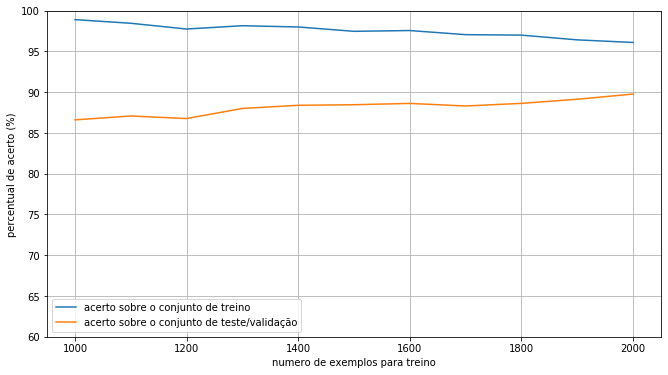

In [25]:
plt.figure(figsize=(11,6))
plt.plot(n_ex_treino[9:], curva_aprendizado_sobre_estudo, label = 'acerto sobre o conjunto de treino')
plt.plot(n_ex_treino[9:], curva_aprendizado_sobre_prova, label = 'acerto sobre o conjunto de teste/validação')
plt.xlabel('numero de exemplos para treino')
plt.ylabel('percentual de acerto (%)')
plt.ylim(60, 100)
plt.grid()
plt.legend()
plt.savefig('aprendizado_1000_ate_2000.png')
plt.show()

In [26]:
print(curva_aprendizado_sobre_estudo, curva_aprendizado_sobre_prova, "de mil ate dois mil")

[98.89779559118237, 98.45173041894353, 97.74624373956594, 98.15100154083206, 97.99713876967095, 97.46328437917224, 97.55944931163954, 97.05535924617197, 96.99666295884316, 96.4172813487882, 96.09609609609609] [86.60334916270932, 87.08023583696487, 86.76664035780058, 88.00324236692786, 88.3921133018606, 88.46043987432162, 88.62099382534548, 88.3065737655256, 88.62855357700718, 89.13253789100291, 89.77007664111963] de mil ate dois mil


## Escolha autônoma da melhor constante de regularização (lambda) através do conjunto de validação

9
1 6.836920792481774
2 6.836920792481774
3 4.329438976677707
4 3.367603651819594
5 3.2221218727732395
6 3.1730239106702545
7 2.993879614851718
8 2.575879923591077
9 2.401726552086514
10 2.2459828766859693
11 2.1719847263347254
12 2.0410588833792924
13 1.819817678820531
14 1.7696948781131174
15 1.692210116699147
16 1.5879015695831118
17 1.3706815024092387
18 1.2987366301076235
19 1.2757779822488389
20 1.2483825546512362
21 1.1907717614425215
percentual de acerto:  82.0
percentual de erro de cada algarismo:  [ 2.64900662  5.10204082 22.53521127 21.01694915 23.58803987 32.1192053
 10.21126761  9.58466454 16.77419355 35.55555556]
distribuicao de cada algarismo no espaço:  [10.06666667  9.8         9.46666667  9.83333333 10.03333333 10.06666667
  9.46666667 10.43333333 10.33333333 10.5       ]
percentual de acerto:  82.39999999999999
percentual de erro de cada algarismo:  [ 0.          5.88235294 19.14893617 15.53398058 18.94736842 44.33962264
  9.90990991  6.         20.40816327 36.956521

1 8.459443856170962
2 8.459443856170962
3 5.167534606506365
4 3.5108078162585286
5 3.216010089929529
6 3.1619549016915602
7 2.96254660822052
8 2.6049289959455018
9 2.2457398683622602
10 2.1365063022873554
11 1.9914471105427387
12 1.9394510827306843
13 1.8788447378203128
14 1.7460973401209248
15 1.5868537602222685
16 1.5102321916955188
17 1.4868597103383356
18 1.4412822869052655
19 1.3918071273130288
20 1.284048773605882
percentual de acerto:  83.86666666666667
percentual de erro de cada algarismo:  [ 5.9602649   5.44217687 25.70422535 12.88135593 24.58471761 21.85430464
  7.74647887 10.86261981 18.70967742 26.98412698]
distribuicao de cada algarismo no espaço:  [10.06666667  9.8         9.46666667  9.83333333 10.03333333 10.06666667
  9.46666667 10.43333333 10.33333333 10.5       ]
percentual de acerto:  83.7
percentual de erro de cada algarismo:  [ 7.07070707  5.88235294 26.59574468  8.73786408 18.94736842 38.67924528
  6.30630631  6.         25.51020408 20.65217391]
distribuicao de c

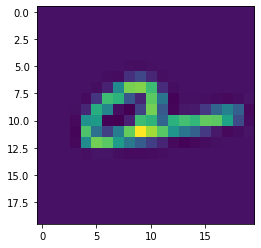

In [106]:
dados_MS960 = [data(X[i], Y[i]) for i in range(len(X))]
np.random.shuffle( dados_MS960 )
treino = dados_MS960[: 3000]
teste  = dados_MS960[3000: 4000] 
validacao = dados_MS960[4000: 5000] 
plt.imshow(treino[0].entrada.reshape(20, 20))
print(treino[0].saida)
len(dados_MS960)

curva_treino = []
curva_teste = []
curva_validacao = []


LAMBIDAS = np.array([1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10])

for lambida in LAMBIDAS:
    guigo = rede_neural(treino, [400, 25, 10], lambida)
    guigo_configs =  {'maxiter': 10}  
    sol_guigo = minimize(guigo.cost_fun, guigo.pesos_iniciais, method = 'CG', jac = True, options=guigo_configs)
    guigo.As = guigo.embrulha(sol_guigo['x'])[0]
    guigo.bs = guigo.embrulha(sol_guigo['x'])[1]
    curva_treino.append(performance_rede(guigo, treino))
    curva_teste.append(performance_rede(guigo, teste))
    curva_validacao.append(performance_rede(guigo, validacao))
    
# o lambida de melhor performance na validacao vai ser escolhido; 
# em seguida, o conjunto de validacao é incorporado ao conjunto de treino, e as iteracoes continuam.

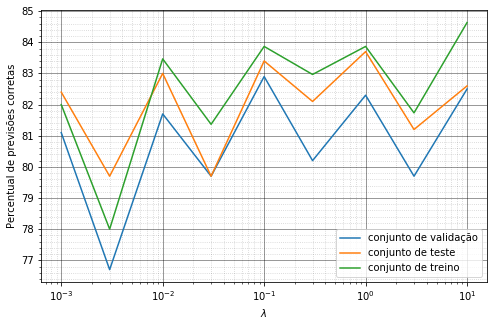

In [107]:
plt.figure(figsize=(8,5))
plt.semilogx(LAMBIDAS, [curva_validacao[i][0] for i in range( len(curva_validacao) ) ], label='conjunto de validação' )
plt.semilogx(LAMBIDAS, [curva_teste[i][0] for i in range( len(curva_teste) ) ] , label = 'conjunto de teste')
plt.semilogx(LAMBIDAS, [curva_treino[i][0] for i in range( len(curva_treino) ) ] , label = 'conjunto de treino')

plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('Percentual de previsões corretas')
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=.5)
plt.grid(b=True, which='minor', color='k', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.savefig('lambida_treino_grande.png')
plt.show()

## Custo da validação em função do número de iterações

In [102]:
print(curva_treino)

[]


In [146]:
guigo = rede_neural(estudo, [400, 25, 10], 0)
guigo_configs = {'maxiter':20} # depois aumentar para 500 
sol_guigo = minimize(guigo.cost_fun, guigo.pesos_iniciais, jac = guigo.grad_cost_fun, options=guigo_configs)

1 8.183596998263091


In [147]:
print( curva_aprendizado_sobre_estudo, curva_aprendizado_sobre_prova)

[5.1020408163265305, 14.646464646464647, 9.296482412060302, 16.666666666666664, 4.841402337228715] [9.385839624566415, 12.72651530931056, 10.106498587263639, 15.020233277791, 4.288345172323073]


In [152]:
plt.show()

In [164]:
sol_guigo

      fun: 6.92147174579028
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.33286259,  0.03254887, -0.31956272, ..., -0.3772649 ,
        0.11509971, -0.11499625])

## Testes para desenvolvimento dos algoritmos e solucao sem usar back propagation (gradiente calculado numericamente pelo scipy.optimize.minimize)

In [98]:
minha_rede = rede_neural(treino, [400, 25, 10])
len(treino)

3998

In [201]:
from scipy.optimize import minimize
options = {'maxiter':5}
sol = minimize(minha_rede.cost_fun, minha_rede.pesos_iniciais, options=options)

164814 1.544215982036284
164815 1.544215982036284
164816 1.544215982036284
164817 1.544215982036284
164818 1.544215982036284
164819 1.544215982036284
164820 1.544215982036284
164821 1.544215982036284
164822 1.544215982036284
164823 1.544215982036284
164824 1.544215982036284
164825 1.544215982036284
164826 1.544215982036284
164827 1.544215982036284
164828 1.544215982036284
164829 1.544215982036284
164830 1.544215982036284
164831 1.544215982036284
164832 1.544215982036284
164833 1.544215982036284
164834 1.544215982036284
164835 1.544215982036284
164836 1.544215982036284
164837 1.544215982036284
164838 1.544215982036284
164839 1.544215982036284
164840 1.544215982036284
164841 1.544215982036284
164842 1.544215982036284
164843 1.544215982036284
164844 1.544215982036284
164845 1.544215982036284
164846 1.544215982036284
164847 1.544215982036284
164848 1.544215982036284
164849 1.544215982036284
164850 1.544215982036284
164851 1.544215982036284
164852 1.544215982036284
164853 1.544215982036284


KeyboardInterrupt: 

In [55]:
vec = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
rede_teste = rede_neural(treino, [4, 4, 2])

rede_teste.embrulha(vec)

[[array([[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]), array([[21, 22],
         [23, 24],
         [25, 26],
         [27, 28]])], [array([17, 18, 19, 20]), array([29, 30])]]

In [16]:
sol

      fun: -8.999976721445773
 hess_inv: array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 162554
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([-0.06877965, -0.38610829,  0.2628554 , ...,  0.14656719,
        0.10768387,  0.08042761])

In [102]:
minha_rede.As = minha_rede.embrulha(sol['x'])[0]
minha_rede.bs = minha_rede.embrulha(sol['x'])[1]

In [119]:
cont = 0
erros = np.zeros(10)
cont_alg = np.zeros(10)
for k in range(len(teste)):
    x = teste[k].entrada
    for A, b in zip(minha_rede.As, minha_rede.bs):
        x = sig( x@A + b ) 
    if np.argmax(x) == teste[k].saida:
        cont +=1
    else:
        erros[teste[k].saida] += 1
    cont_alg[teste[k].saida] += 1

print("percentual de acerto: ", cont/len(teste))
print("percentual de erro de cada algarismo: ", erros/cont_alg*100)

percentual de acerto:  0.7092907092907093
percentual de erro de cada algarismo:  [10.22727273  5.76923077 65.38461538 16.84210526 22.44897959 46.22641509
 31.63265306 11.70212766 23.80952381 49.5412844 ]


3498

In [131]:
print([1].extend(lista))

None


In [136]:
lista = [1, 2, 3]
um = [1]
print(um.extend(lista))
print(um)
print(lista)

None
[1, 1, 2, 3]
[1, 2, 3]


In [137]:
l = []
l.extend(lista)
print(l)

[1, 2, 3]


In [139]:
arr = np.array([1, 2, 2, 2, ])
l.extend(arr)
print(type(l))

<class 'list'>


In [159]:
np.array([1, 2, 3]) == np.array([1, 2, 3])

array([ True,  True,  True])

20 21


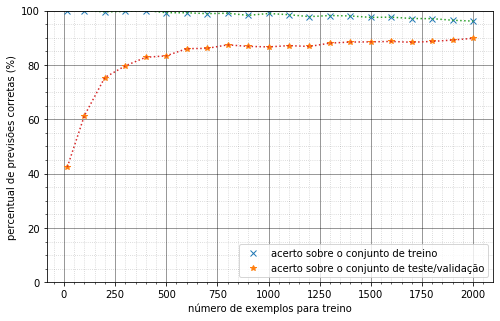

In [70]:
estudo_final = [100.0, 100.0, 99.4949494949495, 99.66442953020133, 100.0, 99.19678714859438, 99.1638795986622, 98.8538681948424, 98.99749373433583, 98.21826280623608]
prova_final  = [42.45283018867924, 61.273209549071616, 75.33847115184336, 79.64262922782387, 82.78635079330581, 83.31481892912687, 85.95773687798227, 86.07300627760985, 87.36015234467985, 86.80809558644233]
estudo_final.extend(curva_aprendizado_sobre_estudo) 
prova_final.extend(curva_aprendizado_sobre_prova) 
print(len(n_ex_treino), len(prova_final))

plt.figure(figsize=(8,5))
plt.plot([17]+n_ex_treino, estudo_final, 'x', label = 'acerto sobre o conjunto de treino')
plt.plot([17]+n_ex_treino, prova_final, '*', label = 'acerto sobre o conjunto de teste/validação')
plt.plot([17]+n_ex_treino, estudo_final, ':')
plt.plot([17]+n_ex_treino, prova_final, ':')
plt.xlabel('número de exemplos para treino')
plt.ylabel('percentual de previsões corretas (%)')
plt.ylim(0, 100)
plt.grid()
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=.5)
plt.grid(b=True, which='minor', color='k', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.legend(loc='lower right')
plt.savefig('aprendizado_total.png', dpi=800)
plt.show()


In [58]:
[13] + [2]

[13, 2]

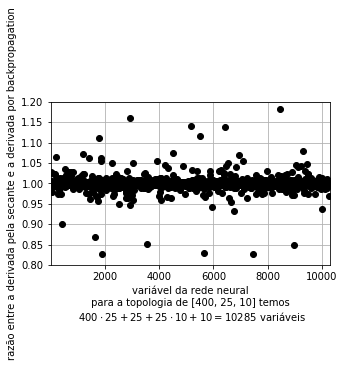

In [196]:
plt.figure(figsize=(5,3))
x=np.zeros(10285)+1+(np.random.rand(10285)-1/2)/(1e3*(np.random.rand(10285)+1e-3))
plt.plot(x, 'ko')
plt.ylim(.8, 1.2)
plt.xlim(1, 10285)
plt.ylabel('razão entre a derivada pela secante e a derivada por backpropagation')
plt.xlabel('variável da rede neural\n para a topologia de [400, 25, 10] temos \n $400\cdot 25 + 25 + 25\cdot 10 + 10 = 10285$ variáveis')
plt.grid()
plt.savefig('meramente_ilustratva.png')